# 2.6% Doping sample,  k=-49 to 49


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import h5py
from scipy import ndimage


import time
import sys
sys.path.append('/share/kim/XTEC/src/xtec')

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from GMM import GMM


In [2]:
# read data, and Qh,Qk,Ql values


DIR = '/share/kim/STEM_Xray_data/xray_from_Josh_Straquadine/PdxErTe3_2x6/PdxErTe3_2x6_'
Tlist = [30,40,50,60,70,80,90,100,125,150,175,200,215,230,250,275,300] #T=30
filepaths = [DIR + str(T) + 'K.nxs' for T in Tlist]
h5py_data_key = 'entry/transform/data/'




filepaths = [DIR + str(T) + 'K.nxs' for T in Tlist]


doc = h5py.File(filepaths[0], 'r')
    
Qh=np.array(doc['entry/transform']['Qh'])
Qk=np.array(doc['entry/transform']['Qk'])
Ql=np.array(doc['entry/transform']['Ql'])



In [3]:
H_Bragg_loc=np.array(Qh%1==0)
K_Bragg_loc=np.array(Qk%1==0)
L_Bragg_loc=np.array(Ql%1==0)

Qh_Bragg=Qh[np.where(H_Bragg_loc)]
Qk_Bragg=Qk[np.where(K_Bragg_loc)]
Ql_Bragg=Ql[np.where(L_Bragg_loc)]



H_Bragg_ind=np.array(np.where(H_Bragg_loc)).flatten()
L_Bragg_ind=np.array(np.where(L_Bragg_loc)).flatten()
K_Bragg_ind=np.array(np.where(K_Bragg_loc)).flatten()

Qk_ind=K_Bragg_ind[abs(Qk[K_Bragg_ind])<50]
cpu_counter=range(len(Qk_ind))

print('Data considered here:')
print('Qh = ', Qh)
print('Ql = ', Ql)
print('Qk = ', Qk[Qk_ind])



Data considered here:
Qh =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Ql =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Qk =  [-49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36.
 -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22.
 -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.
  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.
   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
  49.]


# To plot results, go to part 2

# Part 1. XTEC extraction of CDW peak and peak spread 



# Masks to separate even odd K plane pattern and a* and c* axis CDWs:

## The mask is not necessary (see the notebook with "no mask"). 
However, it cleans the data by avoiding intensities that are otherwise forbidden by selection rules, but present due to possible mosaic defects (streched out intensities along K axis) 
## Using this mask to aim for precision in estimating peak height and spread of CDW peaks

(1001, 1001)


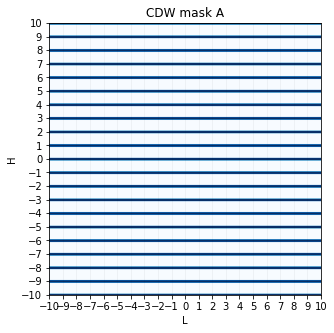

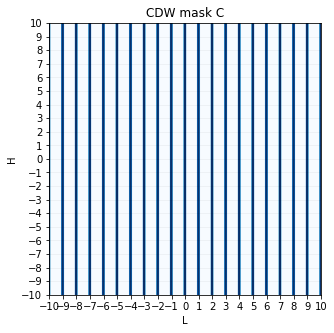

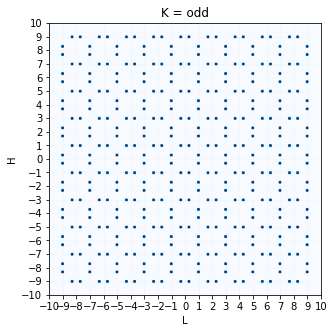

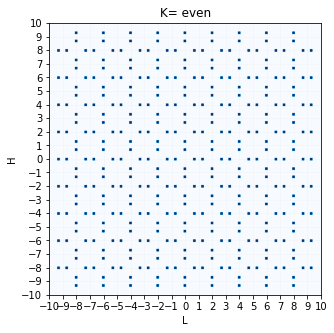

In [4]:
delta=5
delta_a=delta
delta_c=delta

nH=len(Qh)
nL=len(Ql)

mask_A = np.zeros((nH,nL),dtype='int')
mask_C = np.zeros((nH,nL),dtype='int')


count=0
for i in H_Bragg_ind:
    mask_A[max(0,i-delta_a):i+delta_a,:]=1     # north = 1,5,9,... (4n+1)
for i in L_Bragg_ind:
    mask_C[:,max(0,i-delta_c):i+delta_c]=1     # north = 1,5,9,... (4n+1)
    

########   

mask_even = np.ones((nH,nL),dtype='int') # for K=odd plane 
mask_odd  = np.ones((nH,nL),dtype='int')  # for K=even plane


for i in range(50,nH,50):
    for j in range(50,nL,50):
        if((Qh[i]%2 == 0)and(Ql[j]%2==0)):
            mask_even[i-50+delta:i+50-delta,j-50+delta:j+50-delta]=0
        if((Qh[i]%2 == 1)and(Ql[j]%2==1)):
            mask_odd[i-50+delta:i+50-delta,j-50+delta:j+50-delta]=0
            
for j in range(50,nH,50): 
    if((Qh[j]%2==0)):
        mask_even[0:50-delta,j-50+delta:j+50-delta]=0
    if((Ql[j]%2==0)):
        mask_even[j-50+delta:j+50-delta,0:50-delta]=0
mask_even[0:50-delta,0:50-delta]=0 

###################



r_in=10
r_out=20
delta=5






tile_mask = np.zeros((nH,nL),dtype='int')

for i in range(50,nH-50,50):
    for j in range(50,nL-50,50):
        if(i+j)%100 == 50:
            tile_mask[i+r_in:i+r_out,j-delta:j+delta]=1      
            tile_mask[i-r_out:i-r_in,j-delta:j+delta]=1      
            tile_mask[i-delta:i+delta,j+r_in:j+r_out]=1      
            tile_mask[i-delta:i+delta,j-r_out:j-r_in]=1      

mask_even=mask_even*tile_mask
mask_odd=mask_odd*tile_mask
            
            






fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(('CDW mask A'))
ax.set_xlabel('L')
ax.set_ylabel('H')
y_major_ticks = np.array(Qh_Bragg)
x_major_ticks = np.array(Ql_Bragg)
ax.set_yticks(y_major_ticks)
ax.set_xticks(x_major_ticks)

plt.imshow(mask_A[:,:],origin='lower',extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]],cmap='Blues')
plt.grid(color='Black', linestyle='-', alpha=0.05)
    
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(('CDW mask C'))
ax.set_xlabel('L')
ax.set_ylabel('H')
y_major_ticks = np.array(Qh_Bragg)
x_major_ticks = np.array(Ql_Bragg)
ax.set_yticks(y_major_ticks)
ax.set_xticks(x_major_ticks)

plt.imshow(mask_C[:,:],origin='lower',extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]],cmap='Blues')
plt.grid(color='Black', linestyle='-', alpha=0.05)
    

    


        
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
y_major_ticks = np.array(Qh_Bragg)
x_major_ticks = np.array(Ql_Bragg)
ax.set_yticks(y_major_ticks)
ax.set_xticks(x_major_ticks)
ax.set_title(('K = odd'))
ax.set_xlabel('L')
ax.set_ylabel('H')


plt.imshow(mask_even[:,:],origin='lower',extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]],cmap='Blues')
plt.grid(color='#999999', linestyle='-', alpha=0.05)

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
y_major_ticks = np.array(Qh_Bragg)
x_major_ticks = np.array(Ql_Bragg)
ax.set_yticks(y_major_ticks)
ax.set_xticks(x_major_ticks)

ax.set_title(('K= even'))
ax.set_xlabel('L')
ax.set_ylabel('H')


plt.imshow(mask_odd[:,:],origin='lower',extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]],cmap='Blues')
plt.grid(color='#999999', linestyle='-', alpha=0.05)


print(mask_odd.shape)

## Preprocess and obtain various peaks (CDW and others), peak height, peak spread, and background intensity in their neighborhood 

(NB refers to non Bragg intensities, BG for background)

In [5]:
def Process_data_2x6(Thresh_cutoff,delta_hl,delta_k,Qk_ind,cpu_counter):
    
    # data averaged between k-delta_k:Qk+delta_k+1 slices
    K_Bragg=Qk[Qk_ind[cpu_counter]]
    HL_Bragg_ind=[(H_Bragg_ind[q], L_Bragg_ind[r])  for q in range(len(H_Bragg_ind)) for r in range(len(L_Bragg_ind))]

    
    
    data_slice={}
    data = []

    for filepath in filepaths:
        doc = h5py.File(filepath, 'r')
        dataT = doc[h5py_data_key][:,Qk_ind[cpu_counter]-delta_k:Qk_ind[cpu_counter]+delta_k+1,:]
        data.append(dataT)
        doc.close()
    
    data = np.array(data) 
    I=np.mean(data,axis=2)
    I = np.squeeze(I)
    
    
    masked_zeros    = Mask_Zeros(I,'any_zeros')
    if(Thresh_cutoff==None):
        threshold = Threshold_Background(masked_zeros)   # Find cutoff independently for each data
        Thresh_cutoff=threshold.LogI_cutoff
    else:
        threshold = Threshold_Background(masked_zeros,1,'No Thresh',100,Thresh_cutoff) #Use the cutoff previously estimated 

    

    data_slice['I']=I
    data_slice['Tlist'] = Tlist
    
    
    
    nT=I.shape[0]
    nH=I.shape[1]
    nL=I.shape[2]
    
    
    data_slice['I_tot']=np.sum(I)/nT
    
    
    # apply masks to separate c and a axis, as well as the K=even and K = odd pattern
    I_a=np.zeros((nT, nH,  nL))
    I_c=np.zeros((nT, nH,  nL))
    
    if(K_Bragg%2==0):                      
        A_mask=mask_A*mask_odd                       
        C_mask=mask_C*mask_odd                       
    else:
        A_mask=mask_A*mask_even                       
        C_mask=mask_C*mask_even                       
      
        
    for i in range(0,nT):
        I_a[i,:,:]=I[i,:,:]*A_mask
        I_c[i,:,:]=I[i,:,:]*C_mask
    
    
    
    ###########################################################################
    # I_c (Intensity along c axis, containing CDW-1)
    ###########################################################################
    
    masked_c    = Mask_Zeros(I_c,'any_zeros')
    threshold_c = Threshold_Background(masked_c,1,'No Thresh',100,Thresh_cutoff) #Use the cutoff previously estimated 

    num_thresholded  = threshold_c.data_thresholded.shape[1]
    if num_thresholded  == 0:
        print('Thresholding fail')
        return data_slices
    else:
        #print('Num data thresholded=', num_thresholded)
        data_slice['threshold_c']=threshold_c
    
    
    
    max_num_features = 10000
    sector_id=int(cpu_counter)*max_num_features
    
    
    # identify connected features 
    structure_element = np.ones((3,3))    # to identify features if they are connected, even diagonally

    labeled_array, num_features = ndimage.label(threshold_c.thresholded,structure=structure_element)
                    # threshold.thresholded[H,L]=1 if above thresh cutoff 
                    # labelled_array[H,L] has connected features (#num_features) marked by different integers 
    if(num_features>max_num_features):
        print('num features too large', num_features,max_num_features)
        return data_slice
    
    
    
    

    Bragg_labels = [labeled_array[ind] for ind in HL_Bragg_ind]   # labels at Brag_loc
    Bragg_labels = [i for i in Bragg_labels if i != 0]
    Bragg_labels = np.unique(Bragg_labels)



    NonBragg_labels = (np.setdiff1d(list(range(1,num_features)),Bragg_labels)).tolist()  # labels not in Brag_labels
    NonBragg_labels = [i for i in NonBragg_labels if i != 0]
    NonBragg_labels = np.unique(NonBragg_labels)


    
    Bragg_mask    = np.isin(labeled_array,Bragg_labels)           # returns true for labeled arrays that match one of Bragg_labels
    Bragg_ind     = np.array(np.where(Bragg_mask)).transpose()    # h,l indices of   Bragg data, (#Bragg_data, 2) 

    NonBragg_mask = np.isin(labeled_array,NonBragg_labels)           # returns true for labeled arrays that match  NonBragg_labels
    NonBragg_ind  = np.array(np.where(NonBragg_mask)).transpose()    # h,l indices of non Bragg data, (#non_Bragg_data, 2) 


    Bragg_data    = I[:,Bragg_mask]                               # shape=(#T, #bragg_data)   
    
    NonBragg_data = I[:,NonBragg_mask]                            # shape=(#T, #non_bragg_data)  



    data_slice['labeled_array']=labeled_array+sector_id
    data_slice['num_features']=num_features
    data_slice['Bragg_labels']=Bragg_labels+sector_id
    data_slice['NonBragg_labels']=NonBragg_labels+sector_id
    
    
    
    data_slice['Bragg_data']=Bragg_data
    data_slice['Bragg_ind'] = Bragg_ind
    
    data_slice['NonBragg_data']=NonBragg_data
    data_slice['NonBragg_ind'] = NonBragg_ind
    
    
    num_NB=len(NonBragg_labels)
    
    # Find peak tot, peak avg, and peak max intensity, max intensity

    NB_avg = np.zeros((nT,num_NB))       # peak averaged non bragg int, shape=(num_T, num_NB)
    NB_tot = np.zeros((nT,num_NB))
    NB_max = np.zeros((nT,num_NB))
    NB_BG  = np.zeros((nT,num_NB))

    NB_label = np.zeros(num_NB) # labels of peak averaged non bragg intensities
    NB_mom = np.zeros((num_NB,3)) # labels of peak averaged non bragg intensities
    
    
    
    
    
    j=0
    for i in NonBragg_labels:
        label_i    = np.isin(labeled_array,i)
        data_i     = I[:,label_i]
        data_i     = data_i.reshape((data_i.shape[0],np.prod(data_i.shape[1:])))
    
        NB_tot[:,j] = np.sum(data_i, axis=1)   
        NB_avg[:,j] = np.mean(data_i, axis=1)  
        NB_max[:,j] = np.amax(data_i, axis=1) 
        
        
        I_misc     = np.mean(I[0:3],axis=0)*label_i
        P_ind = np.unravel_index(np.argmax(I_misc, axis=None), I_misc.shape)
        NB_mom[j,0] = P_ind[0] # H
        NB_mom[j,1] = P_ind[1] # L
        NB_mom[j,2] = Qk_ind[cpu_counter]
        
        # find Background intensity in a delta (H) x delta (L) nb of the NB peaks
        h1=max(P_ind[0]-delta_hl,0)
        h2=min(P_ind[0]+delta_hl+1,nH-1)
        
        l1=max(P_ind[1]-delta_hl,0)
        l2=min(P_ind[1]+delta_hl+1,nL-1)
        for iT in range(nT):
            BG=I[iT,h1:h2,l1:l2]*(1-threshold.thresholded[h1:h2,l1:l2]) # intensities outside the peak
            if(np.amax(BG)>0):
                x=BG[(BG>0)].flatten()
                BG_avg=np.mean(x)
                NB_BG[iT,j]=BG_avg
        
        NB_label[j]   = i              # label of the jth averaged Non Bragg data point, same as NonBragg_labels
        j+=1
    

    data_slice['NB_avg']=NB_avg
    data_slice['NB_tot'] = NB_tot
    data_slice['NB_max'] = NB_max
    data_slice['NB_mom'] = NB_mom
    data_slice['NB_BG']  = NB_BG # background intensity just outside the peak in a deltaxdelta neighborhood

    
    data_slice['NB_label']=NB_label+sector_id # unique label for this non bragg peak 
    
    
    
    print('Completed k=',K_Bragg, cpu_counter, I.shape)
    return data_slice
    

In [6]:

start_time = time.time()

import multiprocessing as mp
from functools import partial   # partial functions like: func(x,y,z), par=partial(func,2,3) gives par(1)= func(2,3,1)  




delta_hl=25
delta_k=1
Preprocessing = partial(Process_data_2x6,None,delta_hl,delta_k,Qk_ind)
print('num of cpus', 41)
#pool = mp.Pool(mp.cpu_count())
pool = mp.Pool(41) # Leave a couple prcs free
processed_data = pool.map(Preprocessing,cpu_counter)
run_time = time.time() - start_time
print("Total Run Time:",run_time)





num of cpus 41
Completed k= -20.0 29 (17, 1001, 1001)
Completed k= -19.0 30 (17, 1001, 1001)
Completed k= -21.0 28 (17, 1001, 1001)
Completed k= -48.0 1 (17, 1001, 1001)
Completed k= -47.0 2 (17, 1001, 1001)
Completed k= -44.0 5 (17, 1001, 1001)
Completed k= -34.0 15 (17, 1001, 1001)
Completed k= -45.0 4 (17, 1001, 1001)
Completed k= -37.0 12 (17, 1001, 1001)
Completed k= -31.0 18 (17, 1001, 1001)
Completed k= -46.0 3 (17, 1001, 1001)
Completed k= -36.0 13 (17, 1001, 1001)
Completed k= -49.0 0 (17, 1001, 1001)
Completed k= -33.0 16 (17, 1001, 1001)
Completed k= -32.0 17 (17, 1001, 1001)
Completed k= -35.0 14 (17, 1001, 1001)
Completed k= -16.0 33 (17, 1001, 1001)
Completed k= -17.0 32 (17, 1001, 1001)
Completed k= -43.0 6 (17, 1001, 1001)
Completed k= -39.0 10 (17, 1001, 1001)
Completed k= -15.0 34 (17, 1001, 1001)
Completed k= -38.0 11 (17, 1001, 1001)
Completed k= -41.0 8 (17, 1001, 1001)
Completed k= -40.0 9 (17, 1001, 1001)
Completed k= -18.0 31 (17, 1001, 1001)
Completed k= -42.0 

# collect the data together

In [7]:
I_list=[]
I_tot_list=[]
NB_avg_list = []
NB_tot_list = []
NB_max_list = []
NB_mom_list = []
NB_BG_list = []



NB_label_list = []
threshold_list=[]
labeled_array_list=[]

for num, slices in enumerate(processed_data):
    if(len(slices)==3):
        continue
    Tlist=slices['Tlist']
    I_list.append(slices['I'])
    I_tot_list.append(slices['I_tot'])

    NB_avg_list.append(slices['NB_avg'])
    NB_tot_list.append(slices['NB_tot'])
    NB_max_list.append(slices['NB_max'])
    NB_mom_list.append(slices['NB_mom'])
    NB_BG_list.append(slices['NB_BG'])
    
    
    NB_label_list.append(slices['NB_label'])
    
    threshold_list.append(slices['threshold_c'])
    labeled_array_list.append(slices['labeled_array'])

NB_avg = np.hstack(NB_avg_list)  #(num_T, num_NB)
NB_tot = np.hstack(NB_tot_list)  #(num_T, num_NB)
NB_max = np.hstack(NB_max_list)  #(num_T, num_NB)
NB_BG  = np.hstack(NB_BG_list)  #(num_T, num_NB)

NB_mom = np.vstack(NB_mom_list)  #(num_T, num_NB)


NB_label = np.hstack(NB_label_list)  #(num_NB_data) labels for the non bragg data

print(NB_avg.shape)
print(NB_tot.shape)
print(NB_max.shape)
print(NB_BG.shape)

print(NB_mom.shape)



print(NB_label.shape)








(17, 8178)
(17, 8178)
(17, 8178)
(17, 8178)
(8178, 3)
(8178,)


## Clustering

In [8]:
x_train = np.array(Tlist)

# Rescale intensities
#data_post_thresh = NB_avg
data_post_thresh = np.log(NB_avg)
data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0)) #threshold.Rescale_traj(data_post_thresh)
y_train=data_post_thresh_no_mean.transpose() 

print('Data shape',y_train.shape)

Data shape (8178, 17)


(8178, 17)


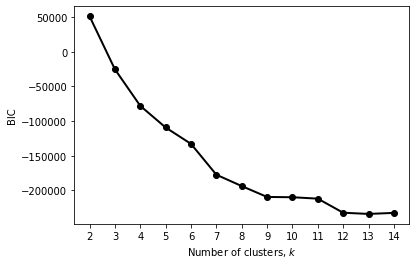

In [9]:
from sklearn import  mixture
ks = np.arange(2,15)
bics = []
print(y_train.shape)
for k in ks:
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='diag')
    gmm.fit(y_train)
    bics.append(gmm.bic(y_train))
    
# Plot the data    
fig, ax = plt.subplots()
ax.plot(ks, bics,marker='o',lw=2,color='black')
ax.set_xlabel(r'Number of clusters, $k$')
ax.set_ylabel('BIC')
ax.set_xticks(ks);







Num per cluster [3259, 1926, 2993]


<module 'matplotlib.pyplot' from '/home/fs01/kmm537/XTEC_venv/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

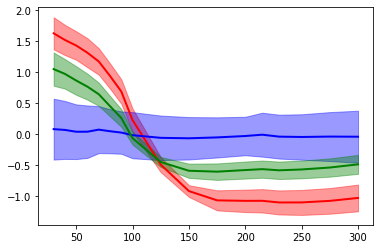

In [40]:
# GMM clustering 
num_clusters = 3
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

In [58]:
import pickle
obj = clusterGMM
pickle.dump( obj, open( "2x6_first_GMM_full_data.p", "wb" ) )

### Plot slices

In [59]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_slice(K_block):
    # ...............Just for a lighter shade of sky blue for background...................................

    K=Qk[Qk_ind[K_block]]
    print('K=', K)
    
    plotting_block = threshold_list[K_block].thresholded.copy()
    labeled_array=labeled_array_list[K_block]


    for k in range(num_clusters):
        cluster_labels = NB_label[(cluster_assignments == k)]
        cluster_mask   = np.isin(labeled_array,cluster_labels)           # returns true for labeled arrays that match  NonBragg_labels
        plotting_block[cluster_mask] = k+2
    
    plotting_slice=plotting_block
    color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
    cluster_cmap = colors.ListedColormap(color_list)
    
    bounds = []
    for i in range(len(color_list)+1):
        bounds.append(i-0.5)
    norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




    fig=plt.figure(figsize=(10,10),dpi=600)
    ax = fig.add_subplot(1, 1, 1)
    y_major_ticks = np.array(Qh_Bragg)
    x_major_ticks = np.array(Ql_Bragg)
    ax.set_yticks(y_major_ticks)
    ax.set_xticks(x_major_ticks)
    ax.set_title(('2.6% doping, K=', K))
    ax.set_xlabel('H')
    ax.set_ylabel('L')


    plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]])
    plt.grid(color='#999999', linestyle='-', alpha=0.05)



    

K= -27.0
K= 1.0
K= 7.0


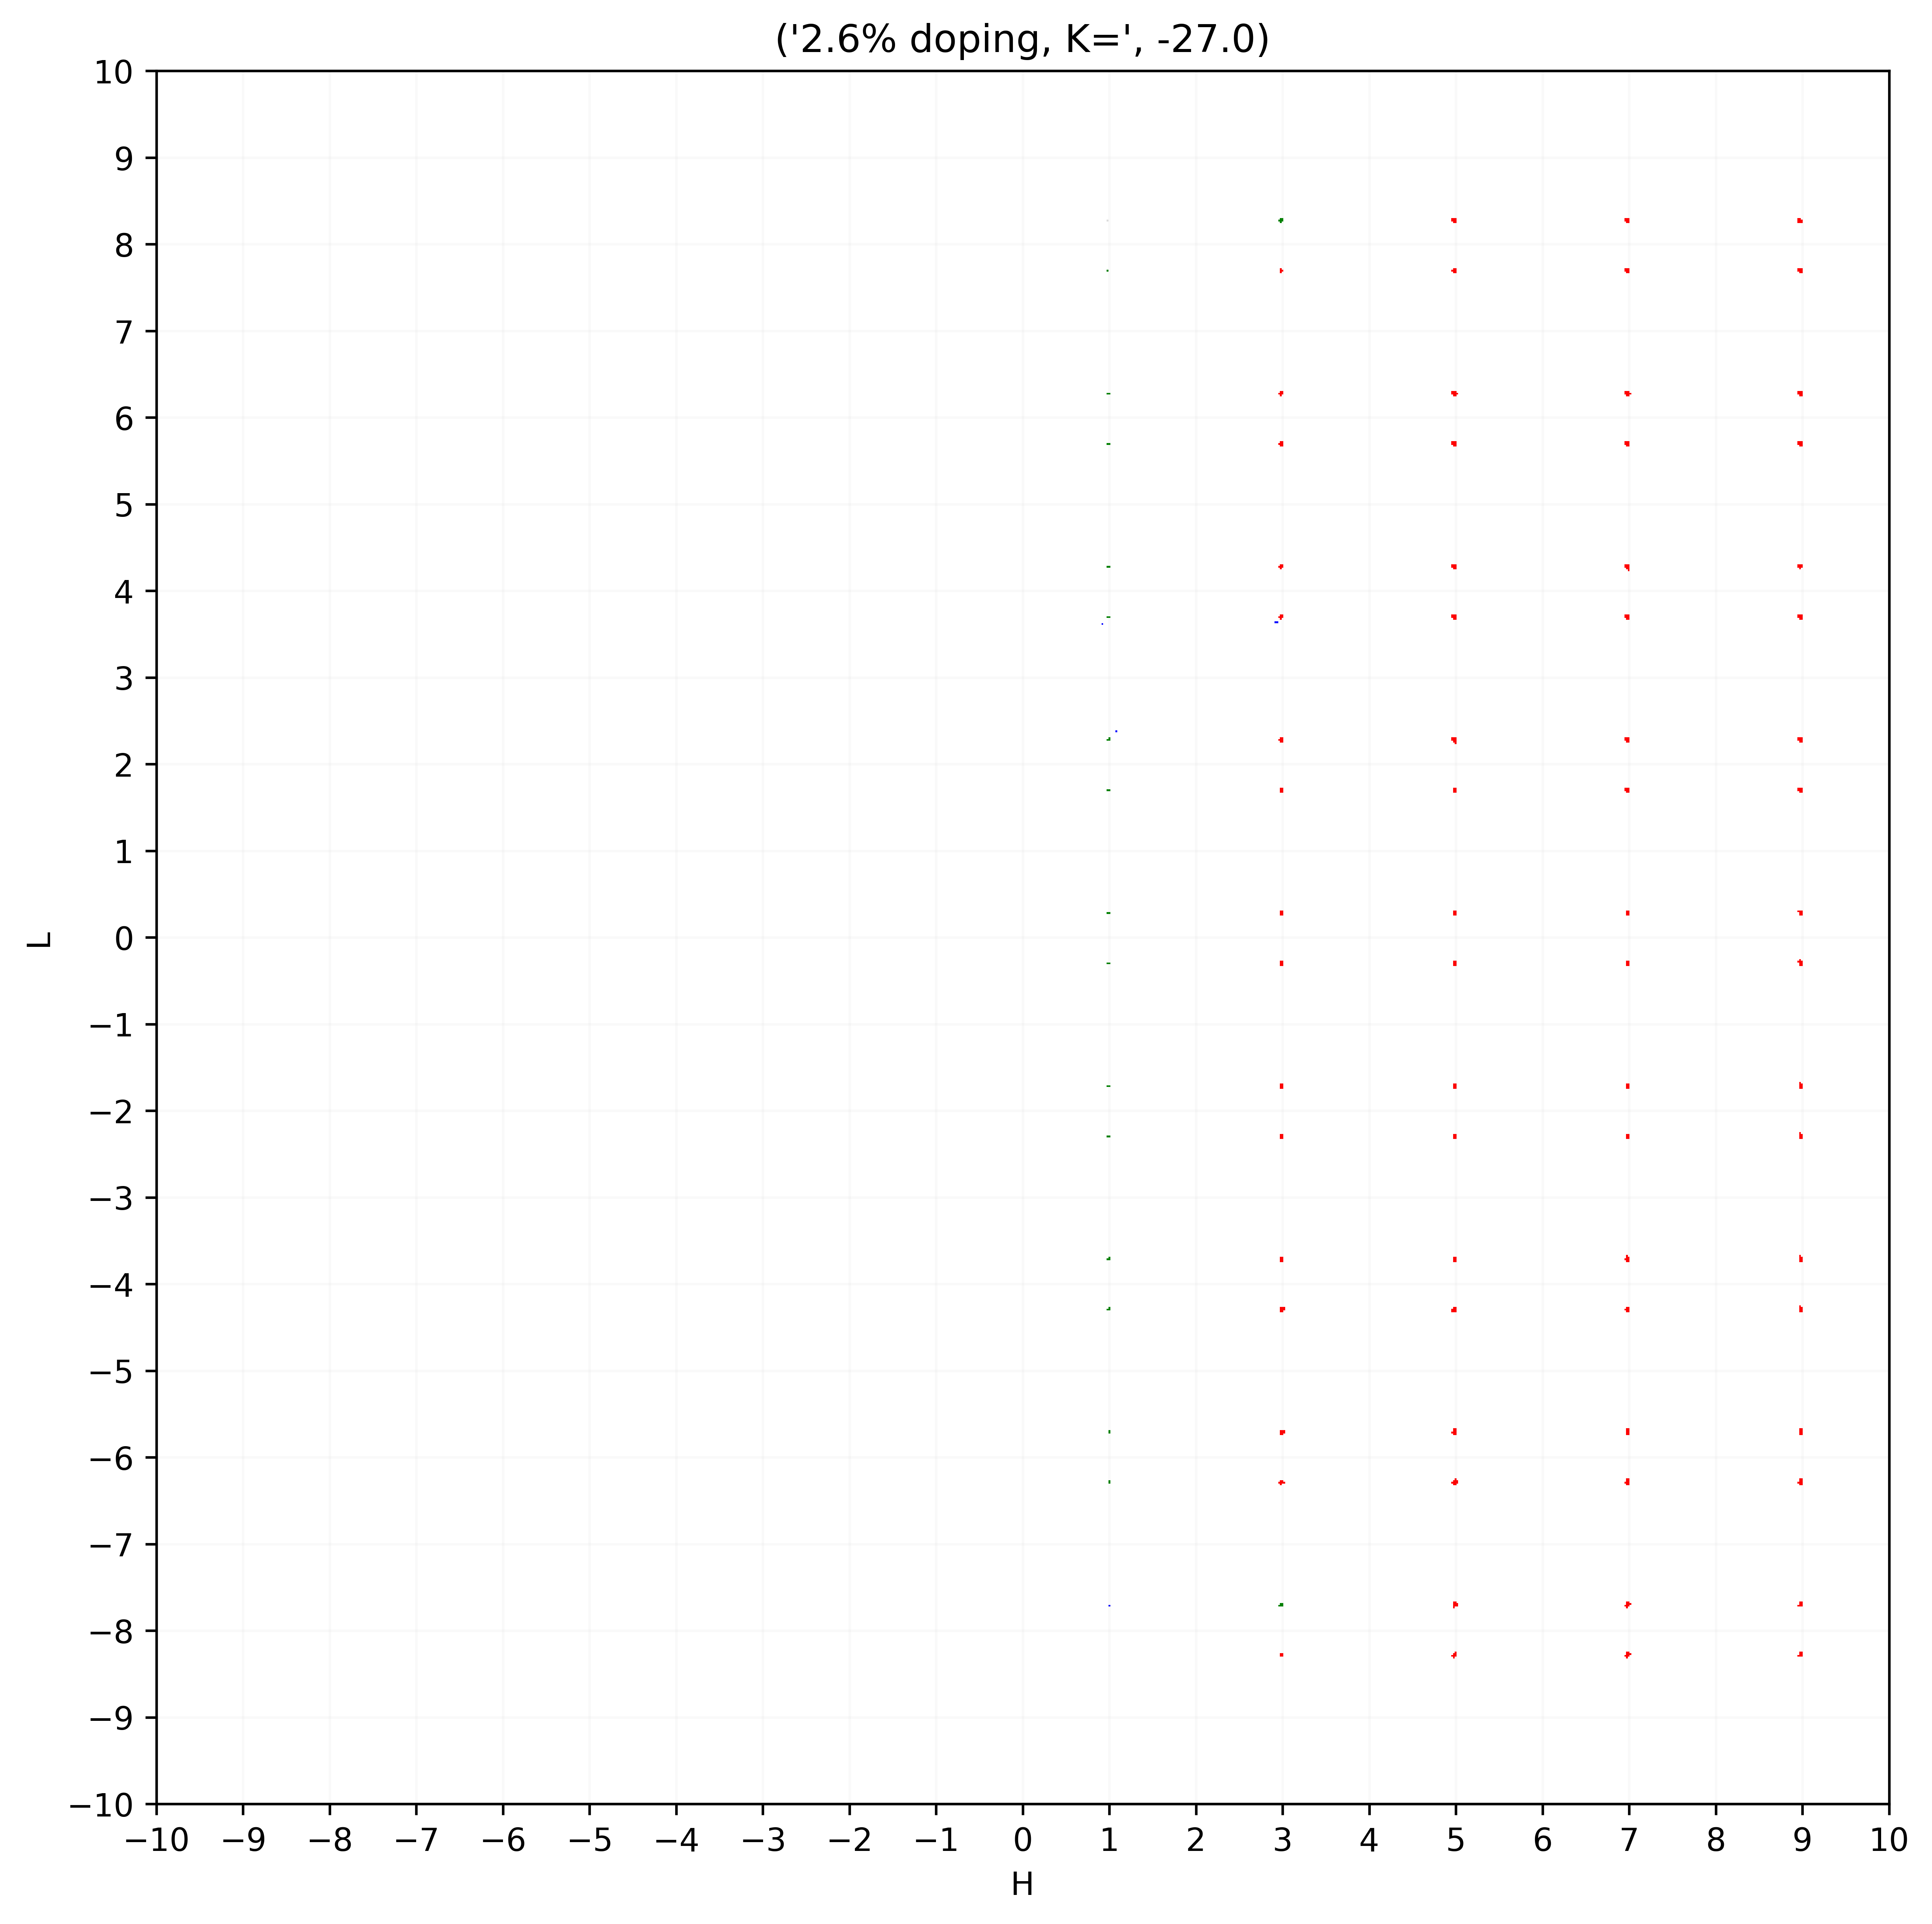

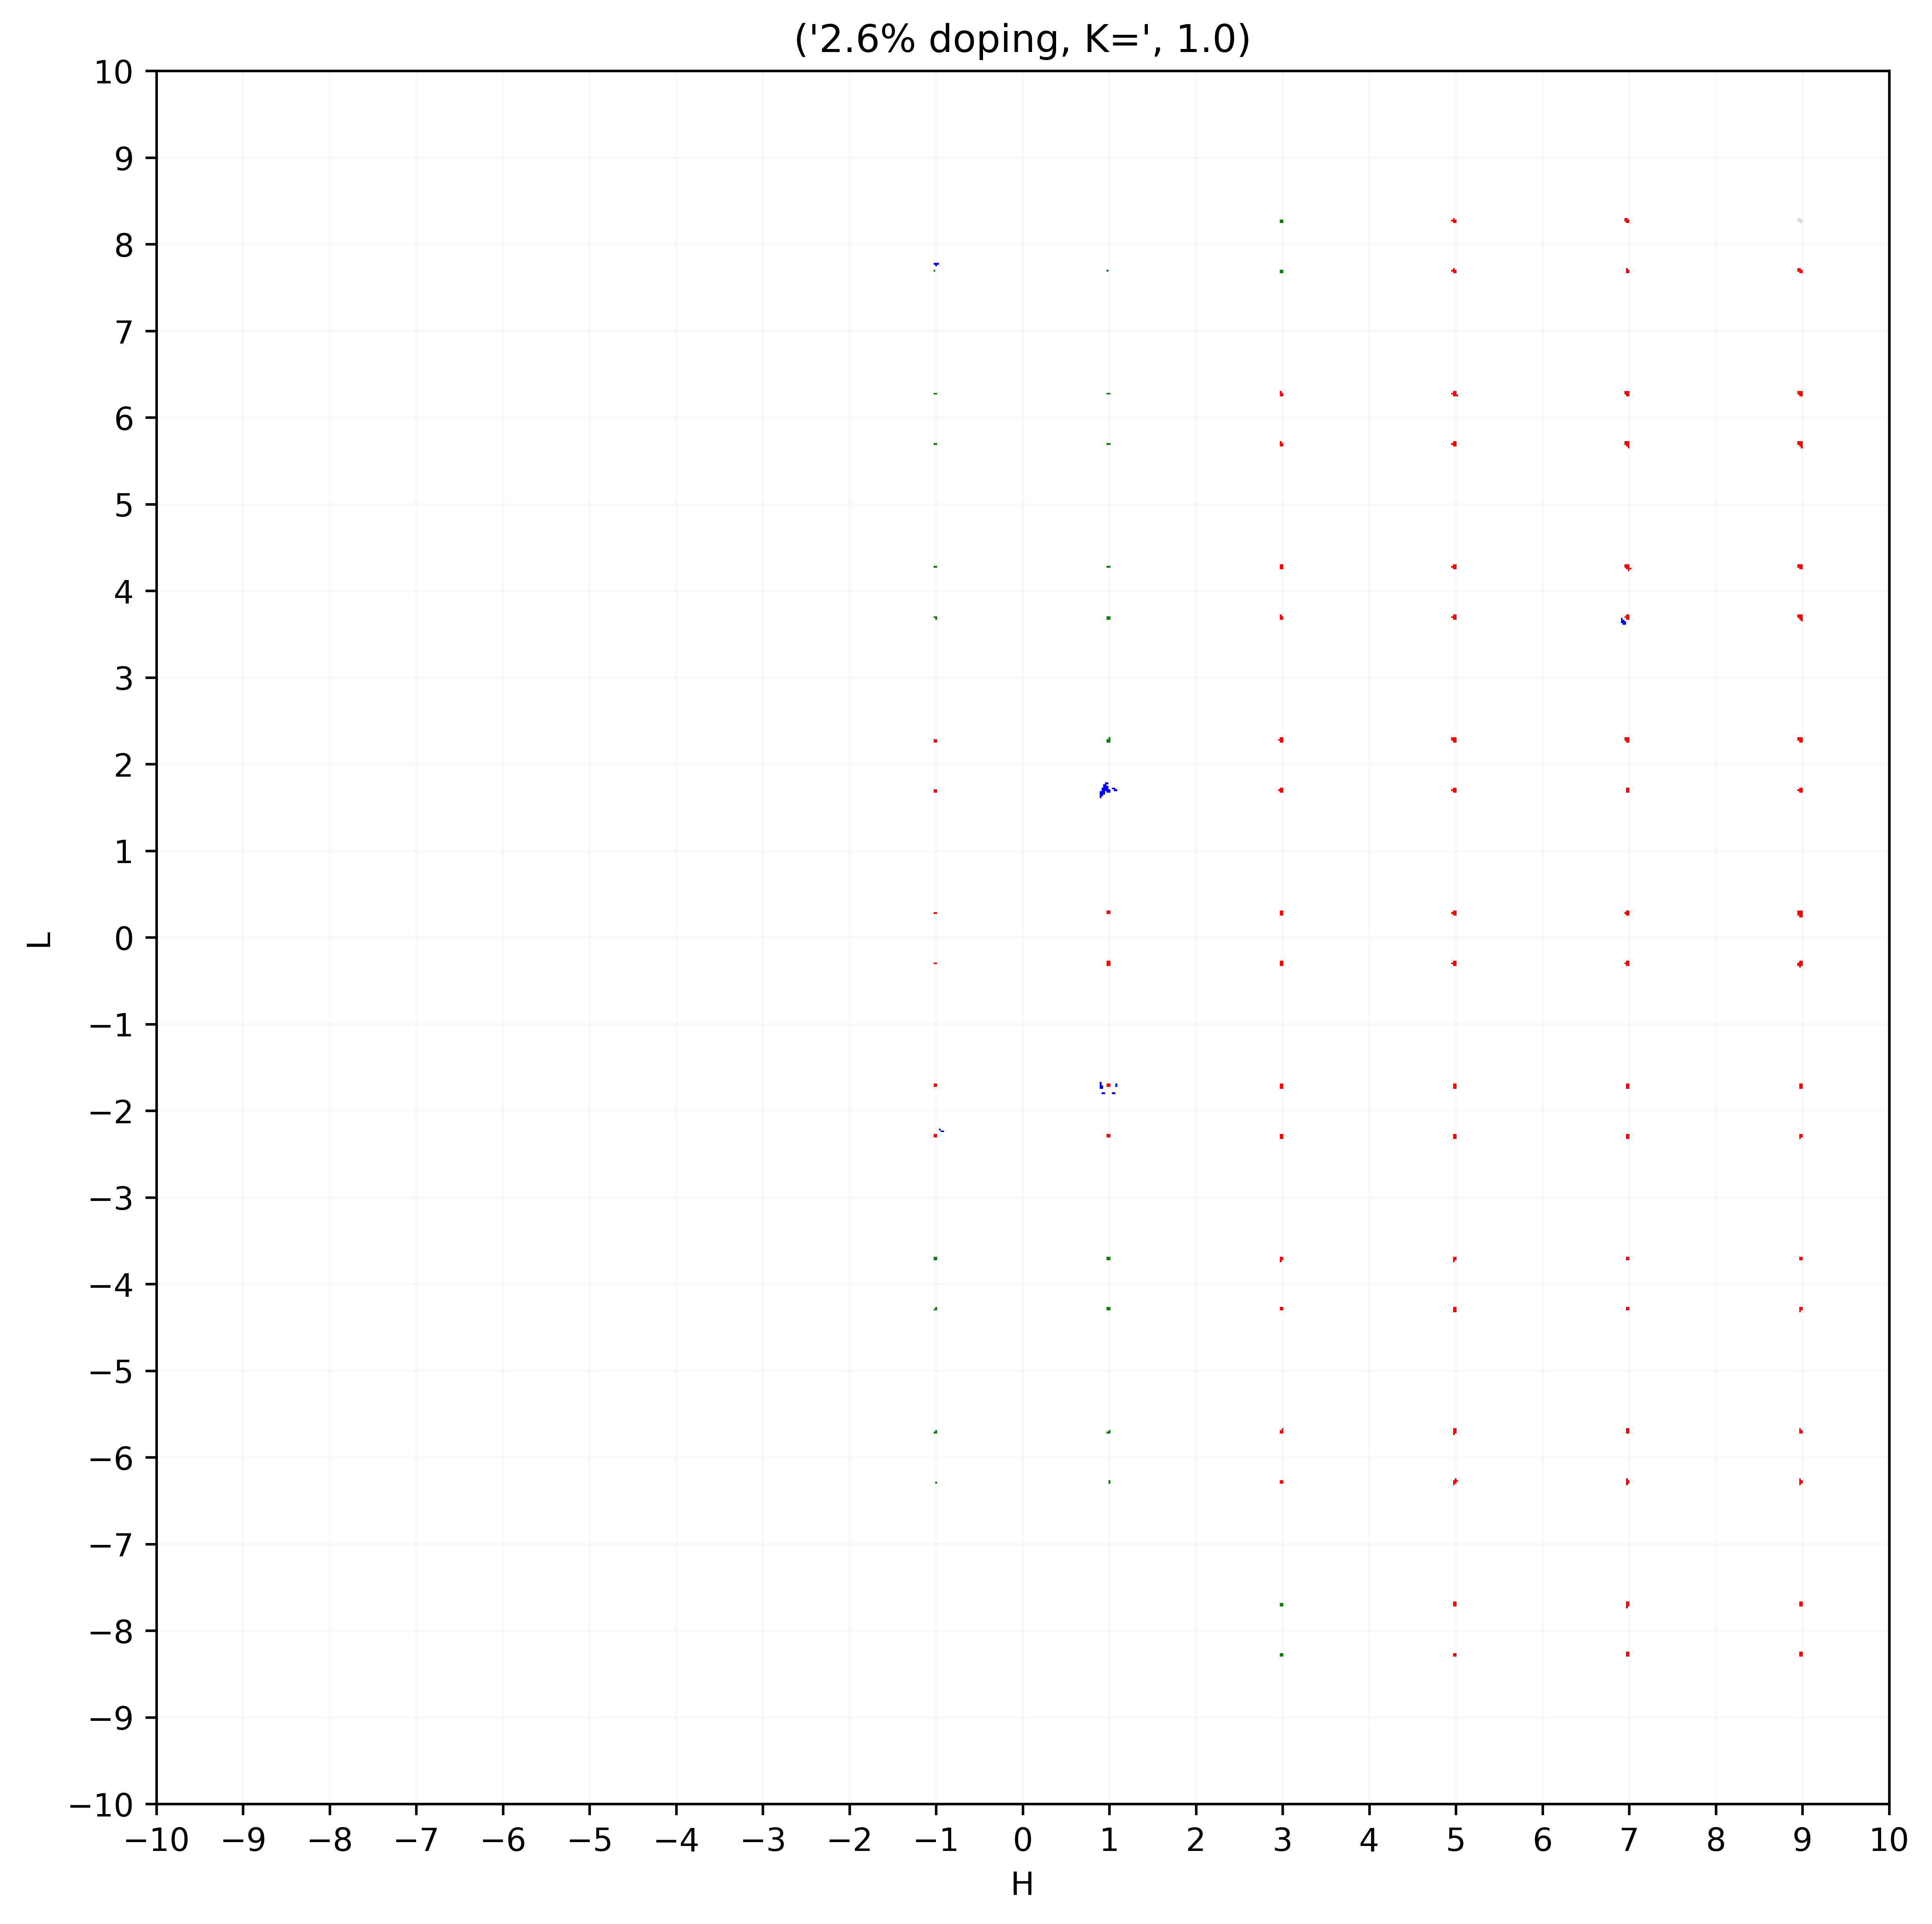

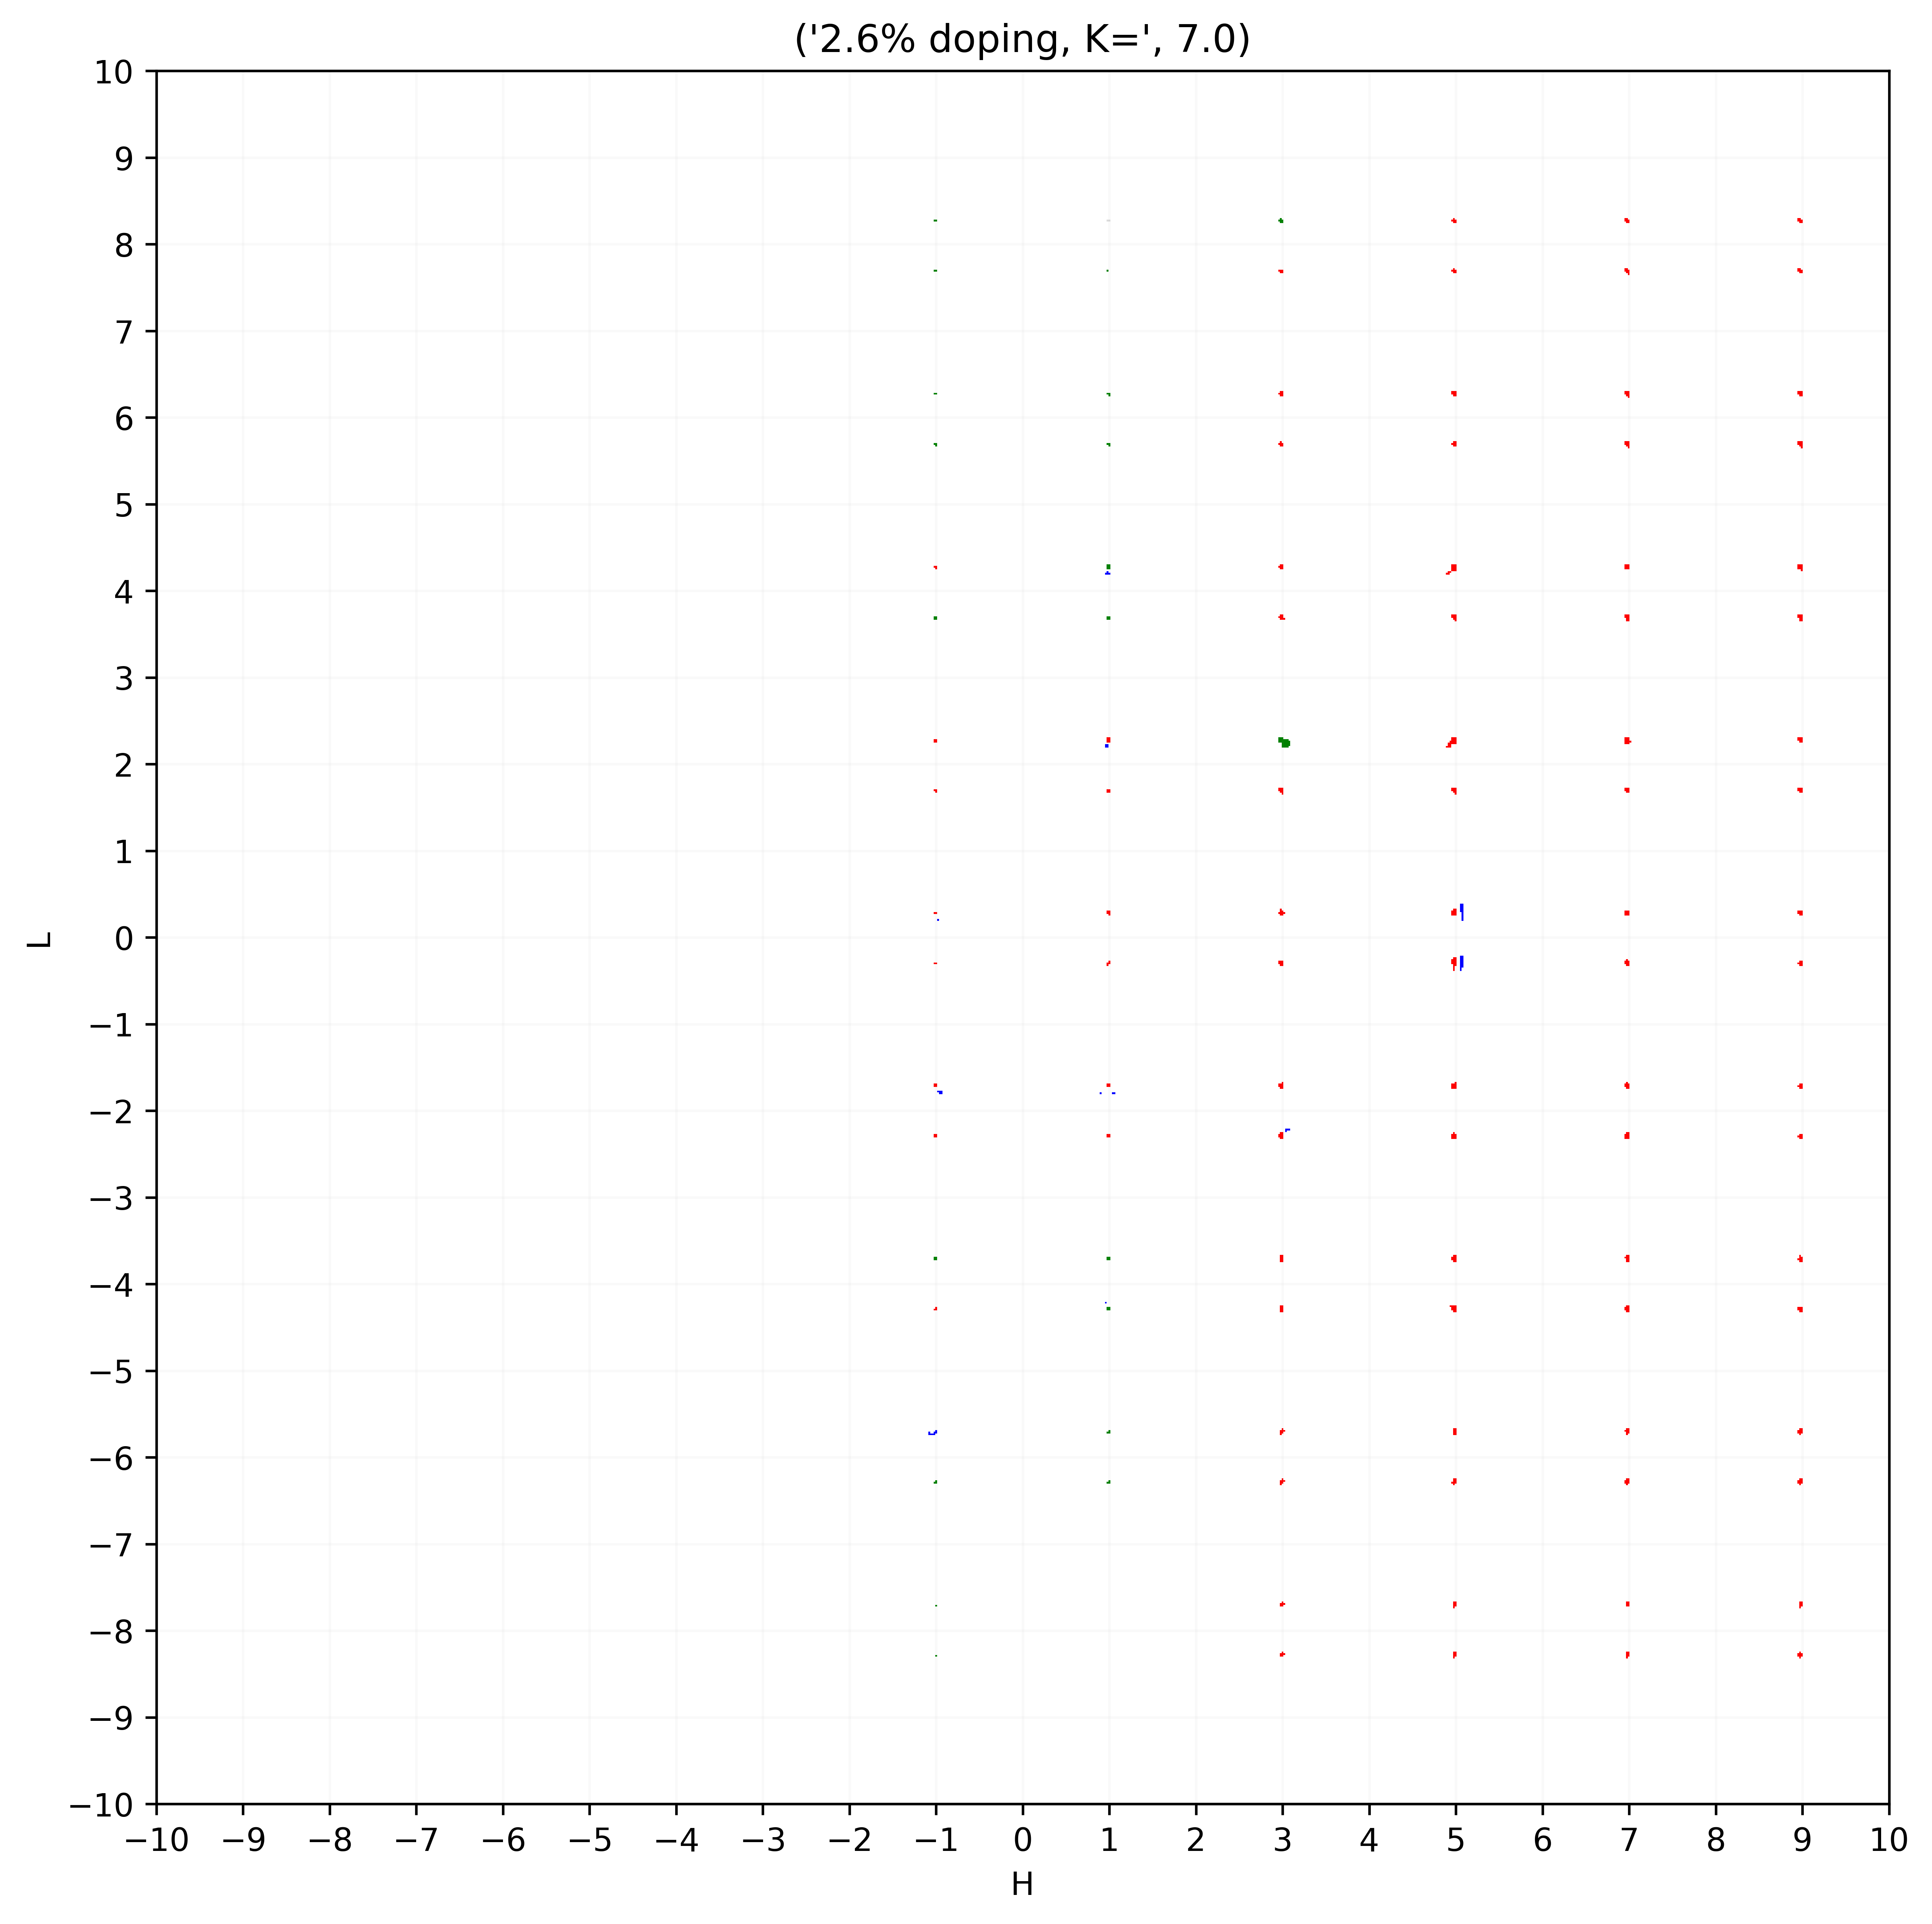

In [42]:
plot_slice(22)
plot_slice(50)
plot_slice(56)


### select CDW cluster

In [43]:
CDW_cluster=[0] # 0 for red, 1 for blue, 2 for green

In [44]:
print('# non Bragg peaks=',NB_label.shape)


CDW_assign  = np.isin(cluster_assignments, CDW_cluster)
CDW_labels =  NB_label[CDW_assign]
CDW_labels =  np.unique(CDW_labels)
num_CDW=len(CDW_labels) 

print('# CDW peaks=',num_CDW)


x           =np.isin(NB_label,CDW_labels)
CDW_max     =NB_max[:,x]
CDW_avg     =NB_avg[:,x]
CDW_tot     =NB_tot[:,x]
CDW_BG      =NB_BG[:,x]

CDW_label   =NB_label[x] #(=CDW labels)
CDW_mom     =NB_mom[x,:]





# non Bragg peaks= (8178,)
# CDW peaks= 3259


# Find spread of CDW peaks

In [45]:
# subtract background intensity

CDW_spread=CDW_tot/CDW_max

CDW_max_BG=CDW_max-CDW_BG
CDW_avg_BG=CDW_avg-CDW_BG
CDW_mom_BG=CDW_mom



n_pix=CDW_tot/CDW_avg
CDW_tot_BG=CDW_tot-CDW_BG*n_pix


print(CDW_tot_BG.shape)
CDW_tot_BG=CDW_tot_BG[:,np.min(CDW_max_BG,axis=0)>0]
CDW_avg_BG=CDW_avg_BG[:,np.min(CDW_max_BG,axis=0)>0]
CDW_mom_BG=CDW_mom_BG[np.min(CDW_max_BG,axis=0)>0,:]
CDW_max_BG=CDW_max_BG[:,np.min(CDW_max_BG,axis=0)>0]






CDW_max_BG=CDW_max_BG[:,np.min(CDW_tot_BG,axis=0)>0]
CDW_avg_BG=CDW_avg_BG[:,np.min(CDW_tot_BG,axis=0)>0]
CDW_mom_BG=CDW_mom_BG[np.min(CDW_tot_BG,axis=0)>0,:]
CDW_tot_BG=CDW_tot_BG[:,np.min(CDW_tot_BG,axis=0)>0]

print(CDW_max_BG.shape)
print(CDW_avg_BG.shape)
print(CDW_tot_BG.shape)
print(CDW_mom_BG.shape)



CDW_spread_BG=CDW_tot_BG/CDW_max_BG

nT=len(Tlist)
T=np.array(Tlist)


(17, 3259)
(17, 2109)
(17, 2109)
(17, 2109)
(2109, 3)


In [60]:
import pickle
obj = {}
obj['CDW_spread_BG']=CDW_spread_BG
obj['CDW_max_BG']=CDW_max_BG
obj['CDW_avg_BG']=CDW_avg_BG
obj['CDW_mom_BG']=CDW_mom_BG
obj['CDW_tot_BG']=CDW_tot_BG

obj['CDW_spread']=CDW_spread
obj['CDW_max']=CDW_max
obj['CDW_avg']=CDW_avg
obj['CDW_mom']=CDW_mom
obj['CDW_tot']=CDW_tot




pickle.dump( obj, open( "CDW_features_2x6_full_data.p", "wb" ) )

# Part 2. Use (load) the XTEC extracted data to get Tc, Tbragg etc

In [4]:
import pickle
obj=pickle.load(open( "CDW_features_2x6_full_data.p", "rb" ) )
CDW_spread_BG=obj['CDW_spread_BG']
CDW_max_BG=obj['CDW_max_BG']
CDW_avg_BG=obj['CDW_avg_BG']
CDW_mom_BG=obj['CDW_mom_BG']
CDW_tot_BG=obj['CDW_tot_BG']

CDW_spread=obj['CDW_spread']
CDW_max=obj['CDW_max']
CDW_avg=obj['CDW_avg']
CDW_mom=obj['CDW_mom']
CDW_tot=obj['CDW_tot']

nT=len(Tlist)
T=np.array(Tlist)

# peak height (peak averaged intensity)

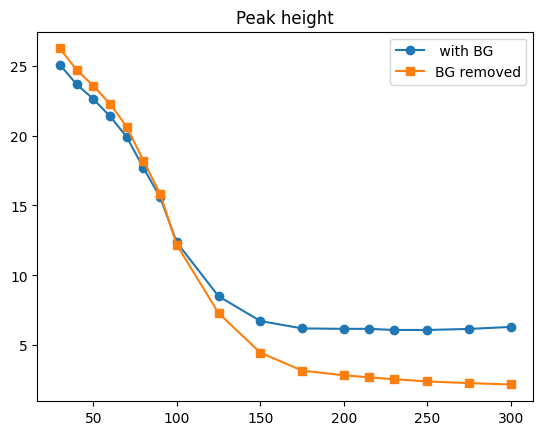

In [5]:

plt.plot(T, np.sqrt(np.mean(CDW_avg,axis=1)),marker='o',label=' with BG')
plt.plot(T, np.sqrt(np.mean(CDW_avg_BG,axis=1)),marker='s', label='BG removed')
plt.title('Peak height')
plt.legend()




In [6]:
peak_height=np.mean(CDW_avg_BG,axis=1).flatten()

# peak spread

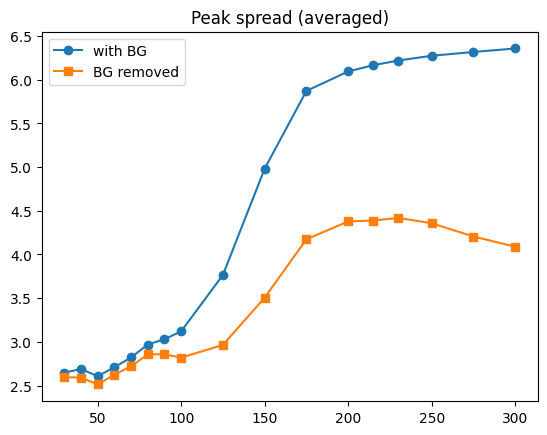

In [7]:
plt.plot(T, np.mean(CDW_spread,axis=1),marker='o',label='with BG')
plt.plot(T, np.mean(CDW_spread_BG,axis=1),marker='s', label='BG removed')
plt.title('Peak spread (averaged)')
plt.legend()



In [8]:
peak_spread=CDW_spread_BG
peak_mom=CDW_mom_BG.astype('int')
print(peak_spread.shape)
print(peak_mom.shape)


(17, 2109)
(2109, 3)


([<matplotlib.axis.YTick at 0x7f4bd9698dc0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

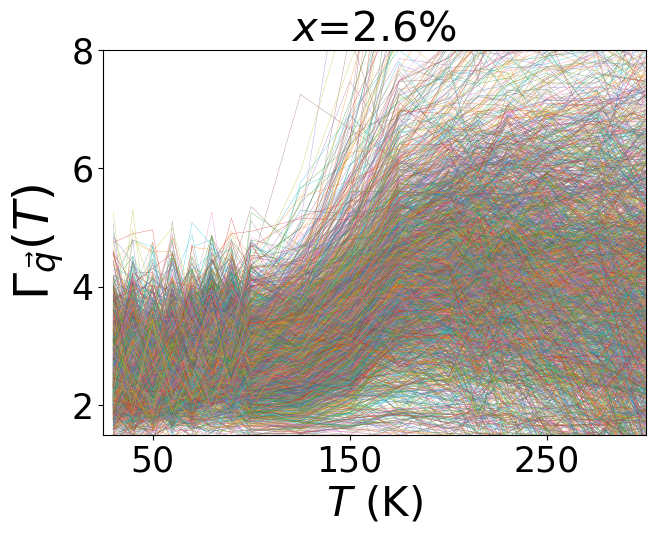

In [9]:
plt.figure(figsize=(7,5))

plt.plot(T,peak_spread,lw=0.2)

plt.ylim([1.5,8])
plt.xlim([25,300])



plt.title(r'$x$=2.6%',fontsize=30)
plt.xlabel('$T$ (K)', fontsize=30)
plt.ylabel (r'$\Gamma_{\vec{q}}(T)$', fontsize=35)
plt.xticks(np.arange(50,300,100),fontsize=25)
plt.yticks(np.arange(2,8.1,2), fontsize=25)
#plt.ylim([0.7,500])
#plt.legend(fontsize=25,frameon=False)


## get momentum dependence

In [9]:
print(Qh[peak_mom[:,1]])
print(Ql[peak_mom[:,0]])
print(Qk[peak_mom[:,2]])


[7.   6.98 8.98 ... 3.98 3.98 4.98]
[-3.72 -2.3  -2.28 ...  2.68  3.26 -0.3 ]
[-49. -49. -49. ...  44.  44.  49.]


In [10]:
from scipy.optimize import curve_fit


def Momentumfit(x, G0, gh,gk, gl):
    return G0+gh*x[:,0]**2+gk*x[:,1]**2+gl*x[:,2]**2


L=(Ql[peak_mom[:,0]]);
H=(Qh[peak_mom[:,1]]);
K=(Qk[peak_mom[:,2]]);
nT=len(Tlist)



X=np.column_stack([H, K, L])   #feature matrix
G0=np.zeros(nT)
gh=np.zeros(nT)
gk=np.zeros(nT)
gl=np.zeros(nT)

G0_err=np.zeros(nT)
gh_err=np.zeros(nT)
gk_err=np.zeros(nT)
gl_err=np.zeros(nT)



for iT in range(nT):
    Y=CDW_spread_BG[iT,:]    
    pars, cov = curve_fit(f=Momentumfit, xdata=X, ydata=Y)
    
    
    G0[iT]=pars[0]
    gh[iT]=pars[1]
    gk[iT]=pars[2]
    gl[iT]=pars[3]
    
    err=np.sqrt(np.diag(cov))
    G0_err[iT]=err[0]
    gh_err[iT]=err[1]
    gk_err[iT]=err[2]
    gl_err[iT]=err[3]
    
    
    
    




([<matplotlib.axis.YTick at 0x7ff306d72e20>,
 [Text(0, -0.06, '−0.06'),
  Text(0, -0.019999999999999997, '−0.02'),
  Text(0, 0.020000000000000004, '0.02')])

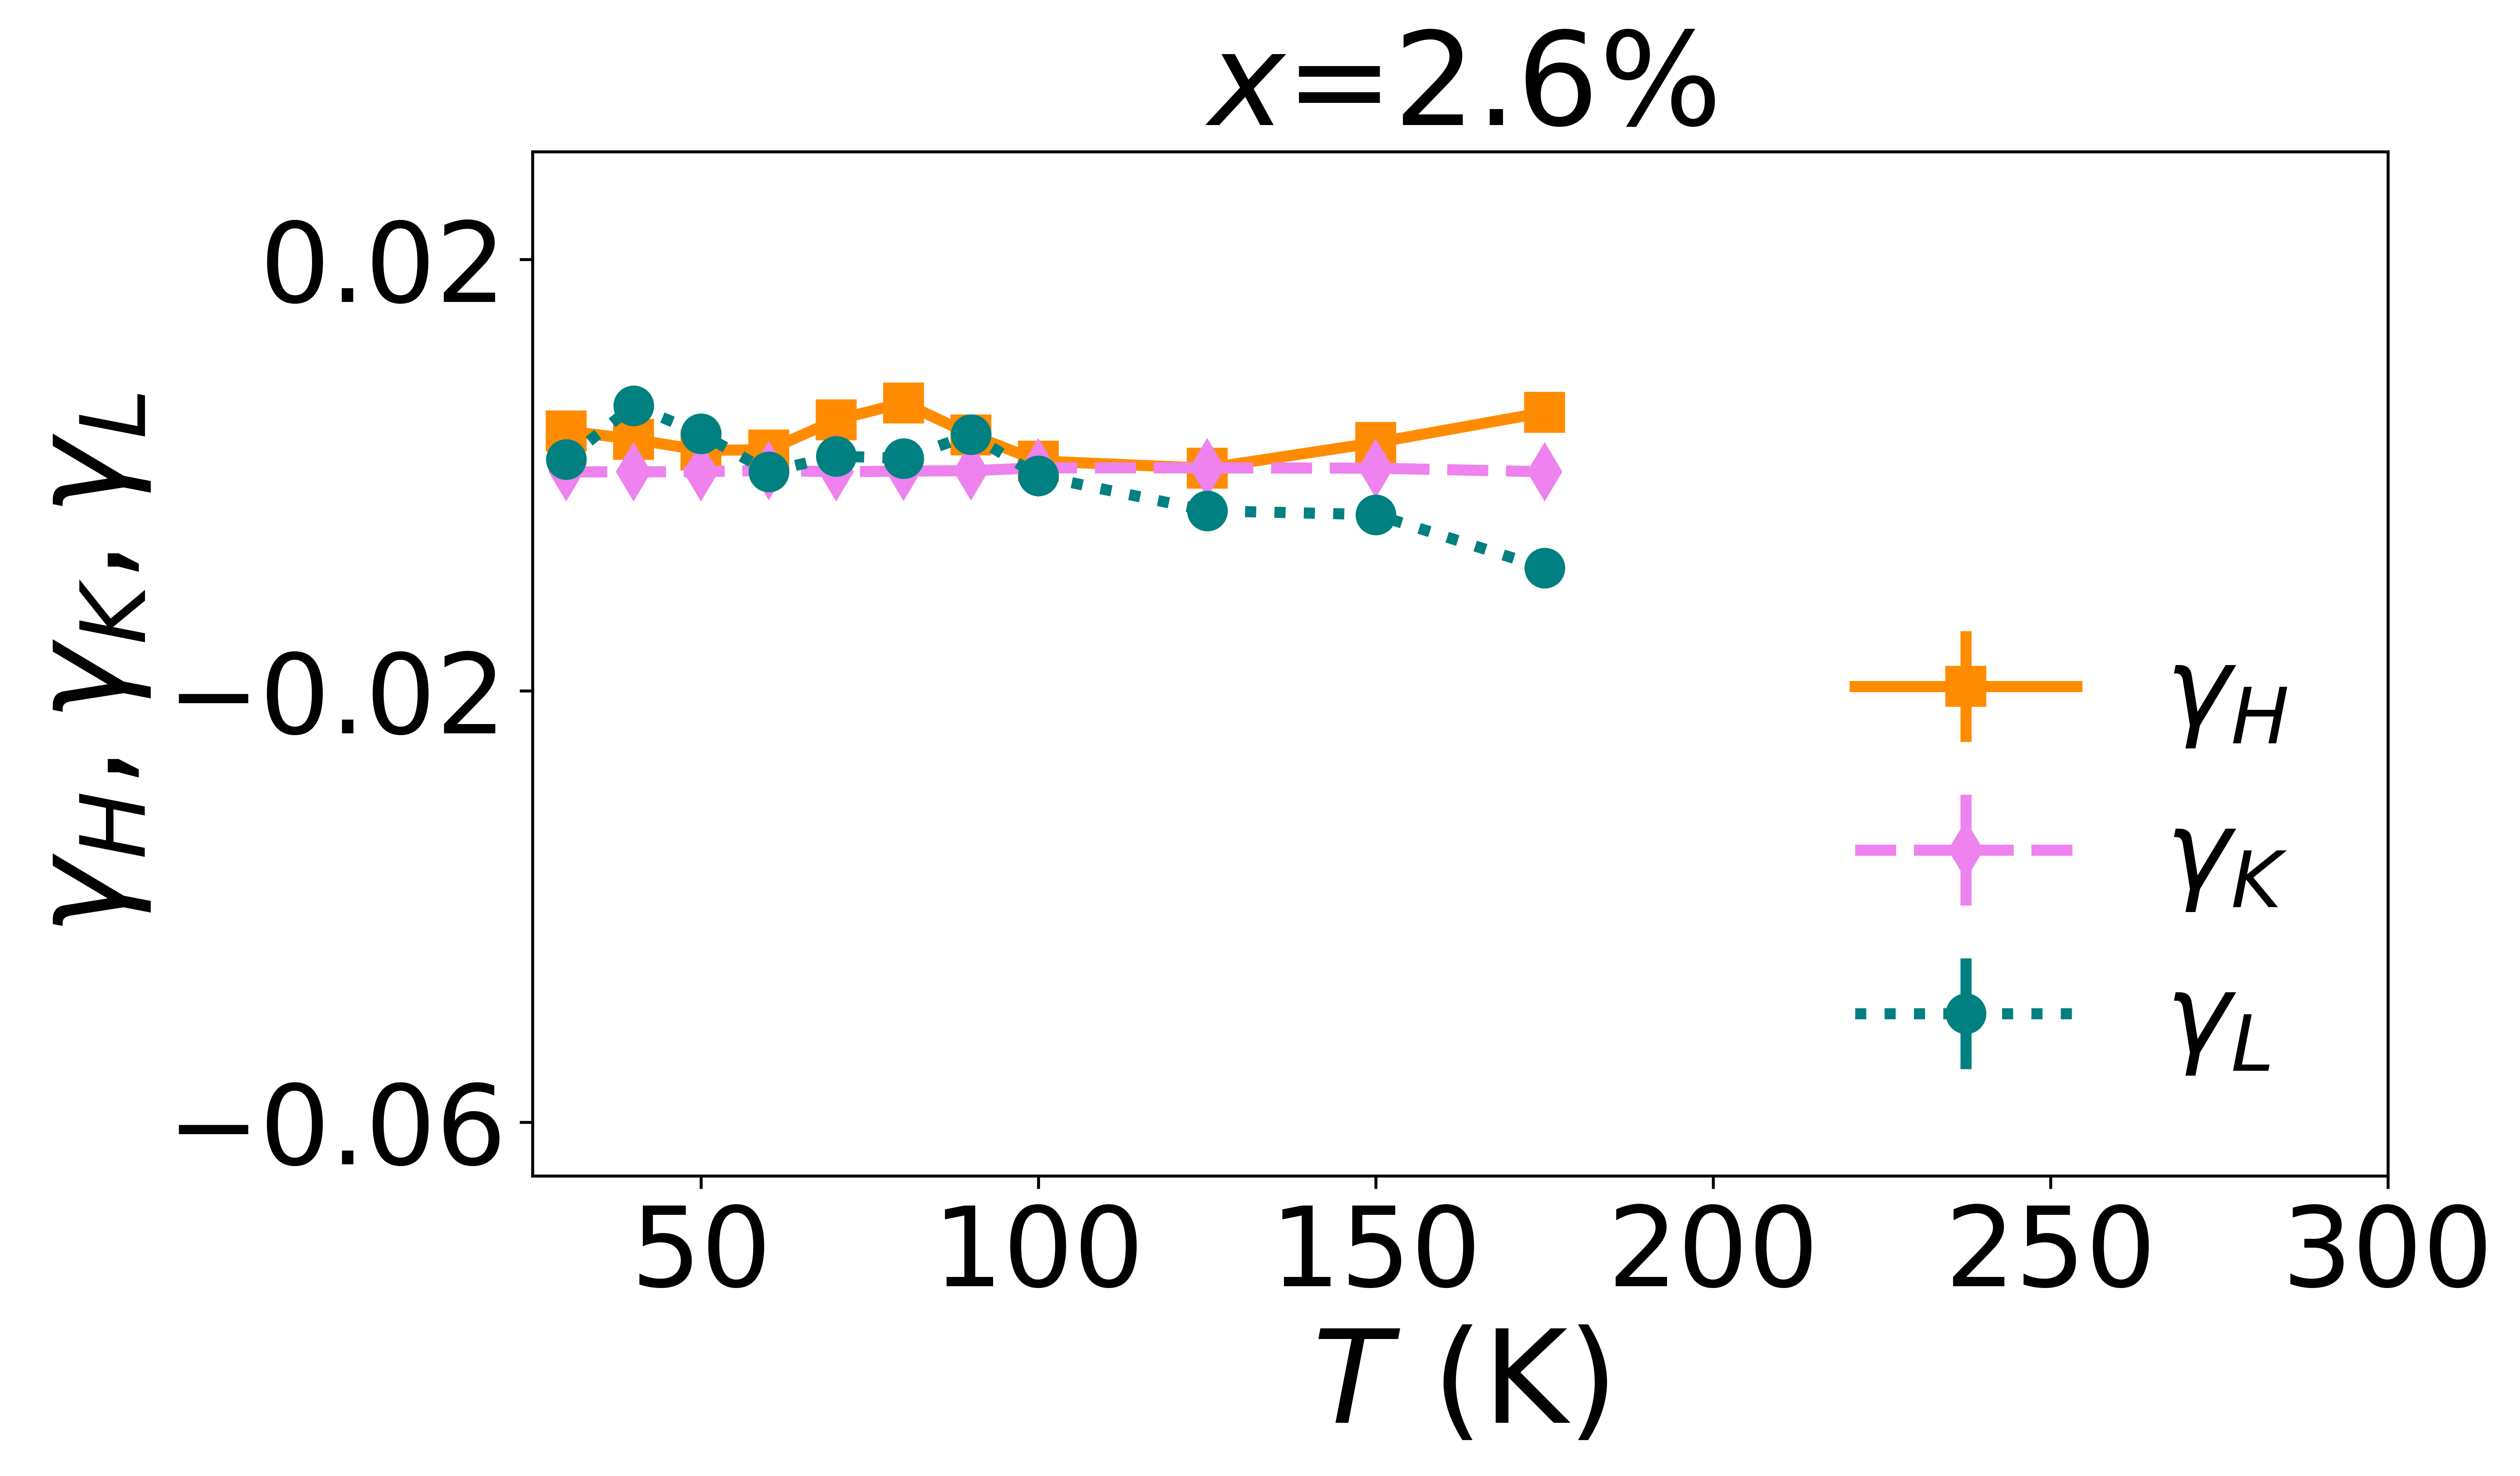

In [12]:
nT_fit=11

plt.figure(figsize=(9,5),dpi=600)

plt.errorbar(T[0:nT_fit],gh[0:nT_fit],gh_err[0:nT_fit],color='darkorange', lw=3.0,linestyle='-',marker='s',markersize=10,label=r'$\gamma_H$')
plt.errorbar(T[0:nT_fit],gk[0:nT_fit],gk_err[0:nT_fit],color='violet', lw=3.0,linestyle='--',marker='d',markersize=10,label=r'$\gamma_K$')
plt.errorbar(T[0:nT_fit],gl[0:nT_fit],gl_err[0:nT_fit],color='teal', lw=3.0,linestyle=':',marker='o',markersize=10,label=r'$\gamma_L$ ')

plt.ylim([-0.065,0.03])
plt.xlim([25,300])



plt.title(r'$x$=2.6%',fontsize=35)
plt.xlabel('$T$ (K)', fontsize=35)
plt.ylabel (r'$\gamma_{H},\gamma_{K},\gamma_{L}$', fontsize=35)
plt.xticks(fontsize=30)
#plt.ylim([0.7,500])
plt.legend(fontsize=30,ncol=1,frameon=False,loc='lower right')
plt.yscale('linear')
plt.yticks((np.arange(-0.06,0.04,0.04)),fontsize=30)


## Compare spread with and without background subtraction

In [13]:
Tlist[11]

200

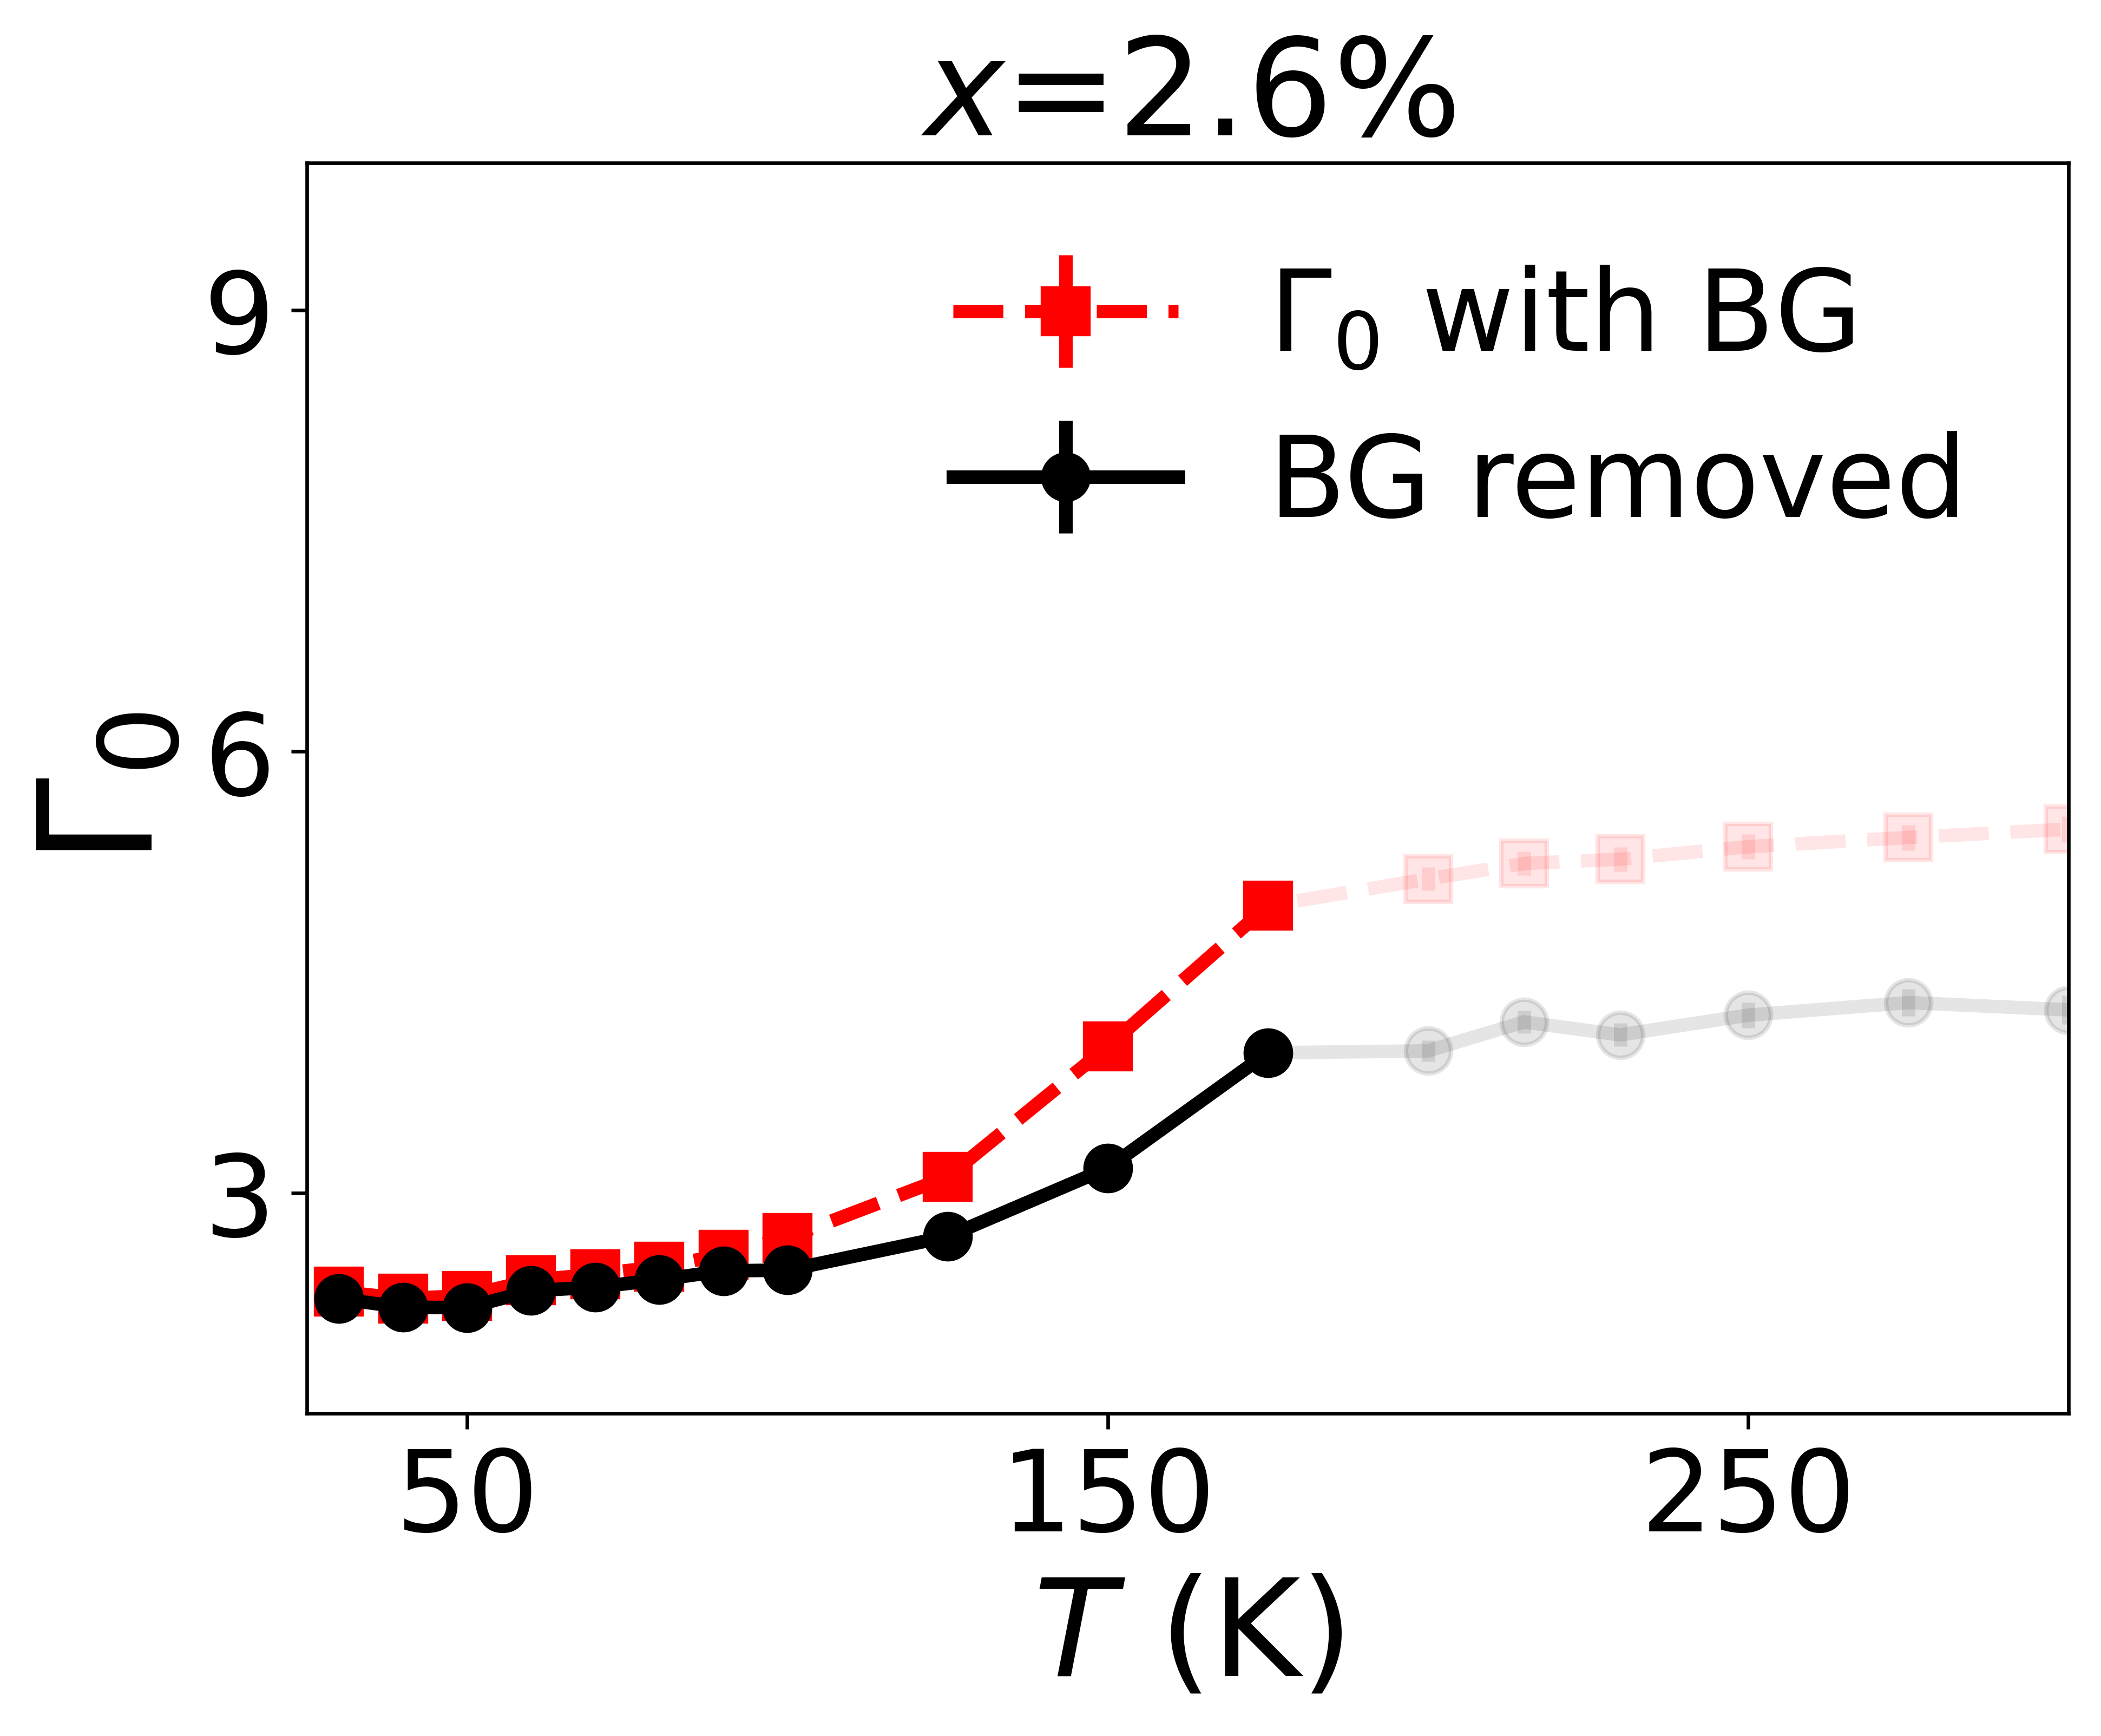

In [14]:
L=(Ql[CDW_mom[:,0].astype(int)]);
H=(Qh[CDW_mom[:,1].astype(int)]);
K=(Qk[CDW_mom[:,2].astype(int)]);



X=np.column_stack([H, K, L])   #feature matrix

G0_with_BG=np.zeros(nT)
gh_with_BG=np.zeros(nT)
gk_with_BG=np.zeros(nT)
gl_with_BG=np.zeros(nT)

G0_err_with_BG=np.zeros(nT)
gh_err_with_BG=np.zeros(nT)
gk_err_with_BG=np.zeros(nT)
gl_err_with_BG=np.zeros(nT)



for iT in range(nT):
    Y=CDW_spread[iT,:]    
    pars, cov = curve_fit(f=Momentumfit, xdata=X, ydata=Y)
    
    
    G0_with_BG[iT]=pars[0]
    gh_with_BG[iT]=pars[1]
    gk_with_BG[iT]=pars[2]
    gl_with_BG[iT]=pars[3]
    
    err=np.sqrt(np.diag(cov))
    G0_err_with_BG[iT]=err[0]
    gh_err_with_BG[iT]=err[1]
    gk_err_with_BG[iT]=err[2]
    gl_err_with_BG[iT]=err[3]
    
    

    




plt.figure(figsize=(7,5),dpi=600)

plt.errorbar(T[0:nT],G0_with_BG[0:nT],G0_err_with_BG[0:nT],color='red', lw=3.0,linestyle='--',marker='s',markersize=10,alpha=0.1)
plt.errorbar(T[0:nT],G0[0:nT],G0_err[0:nT],color='black', lw=3.0,linestyle='-',marker='o',markersize=10,alpha=0.1)

plt.errorbar(T[0:nT_fit],G0_with_BG[0:nT_fit],G0_err_with_BG[0:nT_fit],color='red', lw=3.0,linestyle='--',marker='s',markersize=10,label=r'$\Gamma_0$ with BG')
plt.errorbar(T[0:nT_fit],G0[0:nT_fit],G0_err[0:nT_fit],color='black', lw=3.0,linestyle='-',marker='o',markersize=10,label=r'BG removed')


plt.ylim([1.5,10])
plt.xlim([25,300])



plt.title(r'$x$=2.6%',fontsize=30)
plt.xlabel('$T$ (K)', fontsize=30)
plt.ylabel (r'$\Gamma_0$', fontsize=35)
plt.xticks(np.arange(50,300,100),fontsize=25)
plt.yticks(np.arange(3,10.1,3), fontsize=25)
#plt.ylim([0.7,500])
plt.legend(fontsize=25,frameon=False)




## Get T_Bragg from momentum independent spread, and phenomenological fit

T_BG_max = 112.8430280139217
T_BG = 18.911961194624254


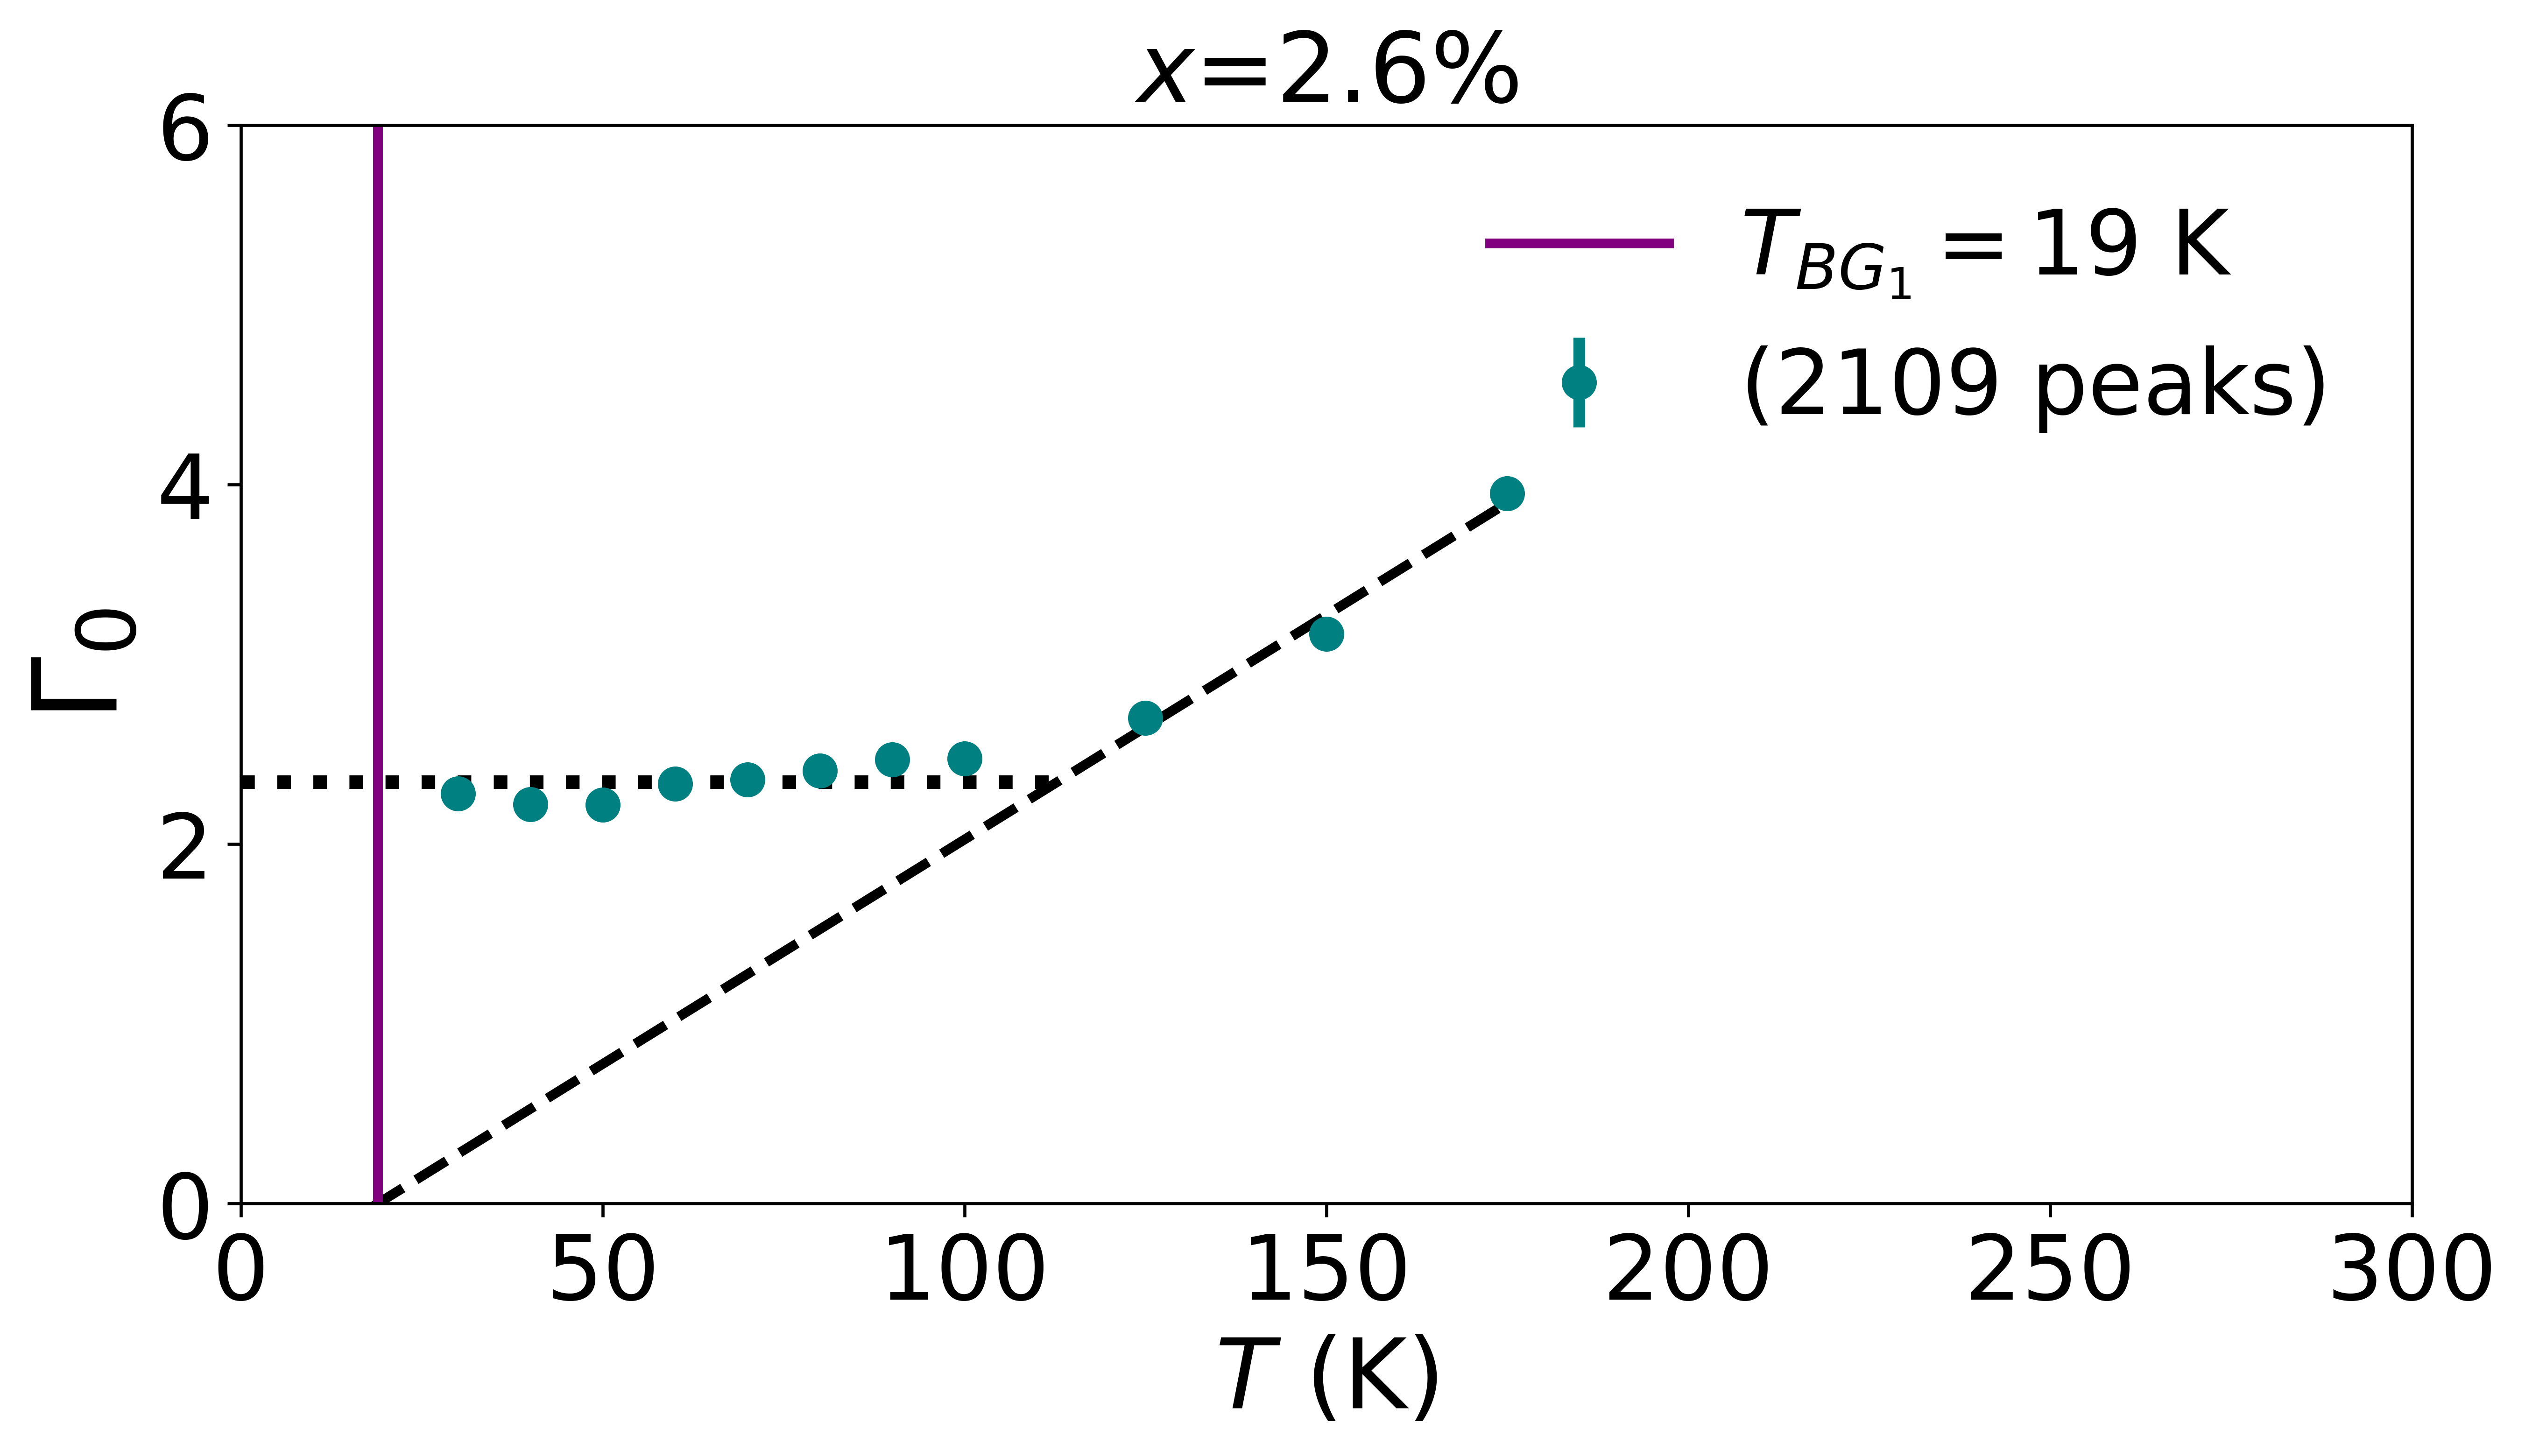

In [16]:
nT_fit=11
G0_fit=G0[0:nT_fit]





# constant+linear fit

x_fit=T[0:nT_fit]
y_fit=G0_fit[0:nT_fit]

def Gammafit(x, a, b,m):
    return a+(m*(x-b))*np.heaviside(x-b,1)


pars, cov = curve_fit(f=Gammafit, xdata=x_fit, ydata=y_fit, p0=[0, 120,0], bounds=((0, 0, 0), (10, 170, 10)))

T_BG=pars[1]-pars[0]/pars[2]
x_fit=np.linspace(0,T[nT_fit-1],600)
y_fit=pars[0]+pars[2]*(x_fit-pars[1])



T_max=pars[1]
print('T_BG_max =',T_max)
print('T_BG =',T_BG)


# constant fit
Gamma_bar=pars[0]
x_bar=[0,T_max]
y_bar=[Gamma_bar,Gamma_bar]

plt.figure(figsize=(10,5),dpi=600)

plt.errorbar(T[0:nT_fit],G0_fit[0:nT_fit],G0_err[0:nT_fit],color='teal', lw=3.0,linestyle=' ',marker='o',markersize=8,label=r'(2109 peaks)')

#plt.errorbar(T,I_coeff,I_err,color='teal', lw=3.0,linestyle=' ',marker='o',markersize=8,label=r'(1986 peaks)')


plt.plot(x_bar,y_bar,color='black', lw=3.5,linestyle=':')







plt.plot(x_fit,y_fit,color='black', lw=2.5,linestyle='--' )

plt.plot([T_BG,T_BG],[-1,8],color='purple', lw=2.5,linestyle='-',label=r'$T_{BG_1}=19$ K' )
#plt.gca().fill_betweenx([-1,5],Tc_fit_min,Tc_fit_max, color='green',alpha=0.1)


plt.ylim([0,6])
plt.xlim([0,300])

TBG_2x0=T_BG

plt.title(r'$x$=2.6%',fontsize=25)
plt.xlabel('$T$ (K)', fontsize=25)
plt.ylabel (r'$\Gamma_0$', fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(np.arange(0,6.5,2),fontsize=23)
#plt.ylim([0.7,500])
plt.legend(fontsize=23,frameon=False,loc='best')
plt.savefig(r'Gamma0_2x6.svg',bbox_inches='tight',transparent='True')



## Get 1D momentum fits on projected data

In [61]:
print(peak_spread[0,:].shape)

L2=(Ql[peak_mom[:,0]])**2;
H2=(Qh[peak_mom[:,1]])**2;
K2=(Qk[peak_mom[:,2]])**2;

(2109,)


In [62]:
def project_1D_momentum(iT, P2):

    Temp=T[iT];

    print('Temp=',Temp)

    y0=peak_spread[iT,:]

    nM=y0.shape[0]
    
    check=np.zeros(nM)
    W_avg=[]
    W_std=[]
    W_p=[] 
    
    for i in range(nM):
        if(check[i]==0):
            P_loc=np.where(np.array(np.abs(np.sqrt(P2)-np.sqrt(P2[i]))<0.1))
            check[P_loc]=1
            p_avg=np.mean(y0[P_loc]);
            p_std=np.std(y0[P_loc]);
            
            
            W_avg.append(p_avg)
            W_std.append(p_std)
            W_p.append(P2[i])
    W_avg=np.array(W_avg)
    W_std=np.array(W_std)
    W_p=np.array(W_p)
    return W_p,W_avg,W_std


Temp= 30
(19,)
(19,)


([<matplotlib.axis.YTick at 0x14f9591edf60>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

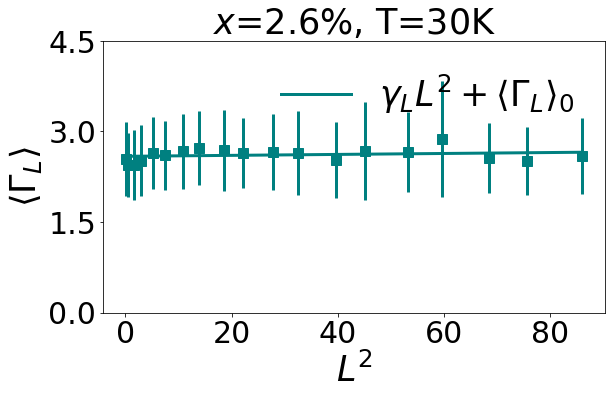

In [39]:
[W_p,W_avg,W_std]=project_1D_momentum(0, L2)
print(W_p.shape)
print(W_std.shape)

c=np.polyfit(W_p, W_avg, 1)  # to get linear fit, m[0]=slope, m[1]=intercept
f=np.poly1d(c)  # linear fitted function 
X=np.linspace(np.min(W_p),np.max(W_p),10)
Y=f(X)



plt.figure(figsize=(9,5))

plt.errorbar(W_p,W_avg,W_std,color='teal', lw=3.0,linestyle=' ',marker='s',markersize=10)
plt.plot(X,Y,color='teal', lw=3.0,linestyle='-',label=r'$\gamma_L L^2+\langle\Gamma_L\rangle_0$')
      
plt.ylim([0,4.5])
plt.title(r'$x$=2.6%, T=30K',fontsize=35)
plt.xlabel('$L^2$', fontsize=35)
plt.ylabel (r'$\langle\Gamma_L\rangle$', fontsize=35)
plt.xticks(fontsize=30)
#plt.ylim([0.7,500])
plt.legend(fontsize=35,frameon=False,loc='best')
plt.yscale('linear')
plt.yticks((np.arange(0.0,4.6,1.5)),fontsize=30)

